# Project Vincero: Monopoly Simulator, RL, and Analysis

In [ ]:
# Setup for environment - run in terminal
# 1. Create a new environment named 'vincero' with Python 3.10 
conda create -n vincero python=3.10 -y

# 2. Activate the environment
conda activate vincero

# 3. Install the required libraries
pip install numpy gymnasium stable-baselines3 torch shimmy seaborn

# 4. Install Jupyter kernel so this environment shows up
conda install ipykernel -y
python -m ipykernel install --user --name=vincero --display-name "Python (Project Vincero)"

# Project Vincero: MonopolyPOMDP Simulation Engine (MonopolyPOMDP.py)
The `MonopolyPOMDP` class implements every rule from the official text as a strict constraint. Key structural decisions include:

* **State Separation:** `TrueState = ObservableState + HiddenState`. The hidden state holds deck permutations and latent opponent risk profiles ($\theta$). Agents only receive `ObservableState` via `get_observation()`.
* **Deck Probability Vectors:** Card counting is exposed as normalized probability dictionaries, updated after every draw/return cycle to account for cards that are kept or returned to the bottom of the deck.
* **Housing Supply:** Hard-capped at **32 houses** and **12 hotels**. If multiple players want the last building, an auction is triggered.
* **Even Building Rule:** Enforced by strictly checking that house variance across a color set never exceeds 1 before any build.
* **Bankruptcy Cascades:**
    * **Debt-to-Player:** Involves property transfer where the new owner must immediately pay the 10% mortgage fee.
    * **Debt-to-Bank:** Properties are returned, mortgages canceled, and properties immediately auctioned. "Get Out of Jail Free" cards are returned to the deck.
* **TradeProposal:** Validates that buildings are sold to the Bank first, computes mandatory 10% mortgage transfer fees, and rejects invalid trades.
* **Rent Logic:**
    * **Streets:** Rent doubles for owning the full color set.
    * **Railroads:** Rent is calculated based strictly on the number of railroads owned.
    * **Utilities:** Rent is 4x the dice roll (1 owned) or 10x the dice roll (2 owned).

In [8]:
"""
Monopoly POMDP Simulation Engine
======================================================
Key fixes from v1:
  - Heuristic players now BUILD houses/hotels every turn
  - Heuristic players attempt TRADES to complete color sets
  - Auction logic is multi-round competitive
  - Buy decisions factor in set completion
  - Building phase runs after every move for ALL players
  - Typical game length: ~200-600 turns (30-80 per player)
"""

from __future__ import annotations
import numpy as np
from enum import Enum, auto
from dataclasses import dataclass, field
from typing import Optional
from copy import deepcopy

# ============================================================
# 1. BOARD & PROPERTY DEFINITIONS
# ============================================================

class SpaceType(Enum):
    GO = auto()
    STREET = auto()
    RAILROAD = auto()
    UTILITY = auto()
    CHANCE = auto()
    COMMUNITY_CHEST = auto()
    INCOME_TAX = auto()
    LUXURY_TAX = auto()
    FREE_PARKING = auto()
    JUST_VISITING = auto()
    GO_TO_JAIL = auto()


class ColorSet(Enum):
    BROWN = "Brown"
    LIGHT_BLUE = "LightBlue"
    PINK = "Pink"
    ORANGE = "Orange"
    RED = "Red"
    YELLOW = "Yellow"
    GREEN = "Green"
    DARK_BLUE = "DarkBlue"
    RAILROAD = "Railroad"
    UTILITY = "Utility"


STREET_COLORS = [
    ColorSet.BROWN, ColorSet.LIGHT_BLUE, ColorSet.PINK, ColorSet.ORANGE,
    ColorSet.RED, ColorSet.YELLOW, ColorSet.GREEN, ColorSet.DARK_BLUE,
]


@dataclass
class PropertyDef:
    name: str
    position: int
    space_type: SpaceType
    color: Optional[ColorSet] = None
    price: int = 0
    mortgage_value: int = 0
    rent: tuple = ()
    house_cost: int = 0
    hotel_cost: int = 0


@dataclass
class BoardSpace:
    name: str
    position: int
    space_type: SpaceType
    prop_def: Optional[PropertyDef] = None


PROPERTY_DEFS: dict[int, PropertyDef] = {
    1: PropertyDef("Mediterranean Avenue", 1, SpaceType.STREET, ColorSet.BROWN,
                   60, 30, (2, 10, 30, 90, 160, 250), 50, 50),
    3: PropertyDef("Baltic Avenue", 3, SpaceType.STREET, ColorSet.BROWN,
                   60, 30, (4, 20, 60, 180, 320, 450), 50, 50),
    6: PropertyDef("Oriental Avenue", 6, SpaceType.STREET, ColorSet.LIGHT_BLUE,
                   100, 50, (6, 30, 90, 270, 400, 550), 50, 50),
    8: PropertyDef("Vermont Avenue", 8, SpaceType.STREET, ColorSet.LIGHT_BLUE,
                   100, 50, (6, 30, 90, 270, 400, 550), 50, 50),
    9: PropertyDef("Connecticut Avenue", 9, SpaceType.STREET, ColorSet.LIGHT_BLUE,
                   120, 60, (8, 40, 100, 300, 450, 600), 50, 50),
    11: PropertyDef("St. Charles Place", 11, SpaceType.STREET, ColorSet.PINK,
                    140, 70, (10, 50, 150, 450, 625, 750), 100, 100),
    13: PropertyDef("States Avenue", 13, SpaceType.STREET, ColorSet.PINK,
                    140, 70, (10, 50, 150, 450, 625, 750), 100, 100),
    14: PropertyDef("Virginia Avenue", 14, SpaceType.STREET, ColorSet.PINK,
                    160, 80, (12, 60, 180, 500, 700, 900), 100, 100),
    16: PropertyDef("St. James Place", 16, SpaceType.STREET, ColorSet.ORANGE,
                    180, 90, (14, 70, 200, 550, 750, 950), 100, 100),
    18: PropertyDef("Tennessee Avenue", 18, SpaceType.STREET, ColorSet.ORANGE,
                    180, 90, (14, 70, 200, 550, 750, 950), 100, 100),
    19: PropertyDef("New York Avenue", 19, SpaceType.STREET, ColorSet.ORANGE,
                    200, 100, (16, 80, 220, 600, 800, 1000), 100, 100),
    21: PropertyDef("Kentucky Avenue", 21, SpaceType.STREET, ColorSet.RED,
                    220, 110, (18, 90, 250, 700, 875, 1050), 150, 150),
    23: PropertyDef("Indiana Avenue", 23, SpaceType.STREET, ColorSet.RED,
                    220, 110, (18, 90, 250, 700, 875, 1050), 150, 150),
    24: PropertyDef("Illinois Avenue", 24, SpaceType.STREET, ColorSet.RED,
                    240, 120, (20, 100, 300, 750, 925, 1100), 150, 150),
    26: PropertyDef("Atlantic Avenue", 26, SpaceType.STREET, ColorSet.YELLOW,
                    260, 130, (22, 110, 330, 800, 975, 1150), 150, 150),
    27: PropertyDef("Ventnor Avenue", 27, SpaceType.STREET, ColorSet.YELLOW,
                    260, 130, (22, 110, 330, 800, 975, 1150), 150, 150),
    29: PropertyDef("Marvin Gardens", 29, SpaceType.STREET, ColorSet.YELLOW,
                    280, 140, (24, 120, 360, 850, 1025, 1200), 150, 150),
    31: PropertyDef("Pacific Avenue", 31, SpaceType.STREET, ColorSet.GREEN,
                    300, 150, (26, 130, 390, 900, 1100, 1275), 200, 200),
    32: PropertyDef("North Carolina Avenue", 32, SpaceType.STREET, ColorSet.GREEN,
                    300, 150, (26, 130, 390, 900, 1100, 1275), 200, 200),
    34: PropertyDef("Pennsylvania Avenue", 34, SpaceType.STREET, ColorSet.GREEN,
                    320, 160, (28, 150, 450, 1000, 1200, 1400), 200, 200),
    37: PropertyDef("Park Place", 37, SpaceType.STREET, ColorSet.DARK_BLUE,
                    350, 175, (35, 175, 500, 1100, 1300, 1500), 200, 200),
    39: PropertyDef("Boardwalk", 39, SpaceType.STREET, ColorSet.DARK_BLUE,
                    400, 200, (50, 200, 600, 1400, 1700, 2000), 200, 200),
    5: PropertyDef("Reading Railroad", 5, SpaceType.RAILROAD, ColorSet.RAILROAD,
                   200, 100, (25, 50, 100, 200)),
    15: PropertyDef("Pennsylvania Railroad", 15, SpaceType.RAILROAD, ColorSet.RAILROAD,
                    200, 100, (25, 50, 100, 200)),
    25: PropertyDef("B&O Railroad", 25, SpaceType.RAILROAD, ColorSet.RAILROAD,
                    200, 100, (25, 50, 100, 200)),
    35: PropertyDef("Short Line", 35, SpaceType.RAILROAD, ColorSet.RAILROAD,
                    200, 100, (25, 50, 100, 200)),
    12: PropertyDef("Electric Company", 12, SpaceType.UTILITY, ColorSet.UTILITY,
                    150, 75, (4, 10)),
    28: PropertyDef("Water Works", 28, SpaceType.UTILITY, ColorSet.UTILITY,
                    150, 75, (4, 10)),
}

COLOR_SET_POSITIONS: dict[ColorSet, list[int]] = {
    ColorSet.BROWN: [1, 3],
    ColorSet.LIGHT_BLUE: [6, 8, 9],
    ColorSet.PINK: [11, 13, 14],
    ColorSet.ORANGE: [16, 18, 19],
    ColorSet.RED: [21, 23, 24],
    ColorSet.YELLOW: [26, 27, 29],
    ColorSet.GREEN: [31, 32, 34],
    ColorSet.DARK_BLUE: [37, 39],
    ColorSet.RAILROAD: [5, 15, 25, 35],
    ColorSet.UTILITY: [12, 28],
}


def _build_board() -> list[BoardSpace]:
    ACTION_SPACES = {
        0: ("GO", SpaceType.GO),
        2: ("Community Chest", SpaceType.COMMUNITY_CHEST),
        4: ("Income Tax", SpaceType.INCOME_TAX),
        7: ("Chance", SpaceType.CHANCE),
        10: ("Just Visiting / Jail", SpaceType.JUST_VISITING),
        17: ("Community Chest", SpaceType.COMMUNITY_CHEST),
        20: ("Free Parking", SpaceType.FREE_PARKING),
        22: ("Chance", SpaceType.CHANCE),
        30: ("Go To Jail", SpaceType.GO_TO_JAIL),
        33: ("Community Chest", SpaceType.COMMUNITY_CHEST),
        36: ("Chance", SpaceType.CHANCE),
        38: ("Luxury Tax", SpaceType.LUXURY_TAX),
    }
    board = []
    for i in range(40):
        if i in PROPERTY_DEFS:
            p = PROPERTY_DEFS[i]
            board.append(BoardSpace(p.name, i, p.space_type, p))
        elif i in ACTION_SPACES:
            name, stype = ACTION_SPACES[i]
            board.append(BoardSpace(name, i, stype))
        else:
            board.append(BoardSpace(f"Space {i}", i, SpaceType.FREE_PARKING))
    return board


BOARD: list[BoardSpace] = _build_board()
INCOME_TAX_AMOUNT = 200
LUXURY_TAX_AMOUNT = 100
GO_SALARY = 200
JAIL_POSITION = 10
GO_TO_JAIL_POSITION = 30
MAX_HOUSES = 32
MAX_HOTELS = 12
STARTING_CASH = 1500
JAIL_FEE = 50
AUCTION_START_BID = 10
PROPERTY_POSITIONS = sorted(PROPERTY_DEFS.keys())


# ============================================================
# 2. CARD DECKS
# ============================================================

class CardAction(Enum):
    ADVANCE_TO = auto()
    ADVANCE_TO_NEAREST_RR = auto()
    ADVANCE_TO_NEAREST_UTIL = auto()
    GO_BACK_3 = auto()
    GO_TO_JAIL = auto()
    COLLECT = auto()
    PAY = auto()
    PAY_EACH_PLAYER = auto()
    COLLECT_FROM_EACH = auto()
    REPAIRS = auto()
    GET_OUT_OF_JAIL = auto()


@dataclass
class Card:
    name: str
    deck: str
    action: CardAction
    value: int = 0
    value2: int = 0

    def __repr__(self):
        return f"Card({self.name!r})"


def _build_chance_deck() -> list[Card]:
    return [
        Card("Advance to Boardwalk", "chance", CardAction.ADVANCE_TO, 39),
        Card("Advance to Go", "chance", CardAction.ADVANCE_TO, 0),
        Card("Advance to Illinois Avenue", "chance", CardAction.ADVANCE_TO, 24),
        Card("Advance to St. Charles Place", "chance", CardAction.ADVANCE_TO, 11),
        Card("Advance to nearest Railroad", "chance", CardAction.ADVANCE_TO_NEAREST_RR),
        Card("Advance to nearest Railroad 2", "chance", CardAction.ADVANCE_TO_NEAREST_RR),
        Card("Advance to nearest Utility", "chance", CardAction.ADVANCE_TO_NEAREST_UTIL),
        Card("Bank pays you dividend of A50", "chance", CardAction.COLLECT, 50),
        Card("Get Out of Jail Free", "chance", CardAction.GET_OUT_OF_JAIL),
        Card("Go Back 3 Spaces", "chance", CardAction.GO_BACK_3),
        Card("Go to Jail", "chance", CardAction.GO_TO_JAIL),
        Card("General repairs A25/house A100/hotel", "chance", CardAction.REPAIRS, 25, 100),
        Card("Speeding fine A15", "chance", CardAction.PAY, 15),
        Card("Advance to Reading Railroad", "chance", CardAction.ADVANCE_TO, 5),
        Card("Chairman: pay each player A50", "chance", CardAction.PAY_EACH_PLAYER, 50),
        Card("Building loan matures: collect A150", "chance", CardAction.COLLECT, 150),
    ]


def _build_cc_deck() -> list[Card]:
    return [
        Card("Advance to Go", "community_chest", CardAction.ADVANCE_TO, 0),
        Card("Bank error: collect A200", "community_chest", CardAction.COLLECT, 200),
        Card("Doctor's fee: pay A50", "community_chest", CardAction.PAY, 50),
        Card("Sale of stock: collect A50", "community_chest", CardAction.COLLECT, 50),
        Card("Get Out of Jail Free", "community_chest", CardAction.GET_OUT_OF_JAIL),
        Card("Go to Jail", "community_chest", CardAction.GO_TO_JAIL),
        Card("Holiday fund: collect A100", "community_chest", CardAction.COLLECT, 100),
        Card("Income tax refund: collect A20", "community_chest", CardAction.COLLECT, 20),
        Card("Birthday: collect A10 from each", "community_chest", CardAction.COLLECT_FROM_EACH, 10),
        Card("Life insurance: collect A100", "community_chest", CardAction.COLLECT, 100),
        Card("Hospital fees: pay A100", "community_chest", CardAction.PAY, 100),
        Card("School fees: pay A50", "community_chest", CardAction.PAY, 50),
        Card("Consultancy fee: collect A25", "community_chest", CardAction.COLLECT, 25),
        Card("Street repairs A40/house A115/hotel", "community_chest", CardAction.REPAIRS, 40, 115),
        Card("Beauty contest: collect A10", "community_chest", CardAction.COLLECT, 10),
        Card("Inherit A100", "community_chest", CardAction.COLLECT, 100),
    ]


# ============================================================
# 3. GAME STATE
# ============================================================

@dataclass
class PropertyState:
    position: int
    owner: Optional[int] = None
    is_mortgaged: bool = False
    houses: int = 0  # 0-4 houses; 5 = hotel


@dataclass
class PlayerState:
    index: int
    cash: int = STARTING_CASH
    position: int = 0
    in_jail: bool = False
    jail_turns: int = 0
    has_goojf_chance: bool = False
    has_goojf_cc: bool = False
    is_bankrupt: bool = False
    doubles_count: int = 0

    @property
    def total_goojf(self) -> int:
        return int(self.has_goojf_chance) + int(self.has_goojf_cc)


@dataclass
class HiddenState:
    chance_deck: list[Card] = field(default_factory=list)
    cc_deck: list[Card] = field(default_factory=list)
    opponent_profiles: dict[int, float] = field(default_factory=dict)


@dataclass
class ObservableState:
    players: list[PlayerState] = field(default_factory=list)
    properties: dict[int, PropertyState] = field(default_factory=dict)
    houses_available: int = MAX_HOUSES
    hotels_available: int = MAX_HOTELS
    current_player: int = 0
    turn_number: int = 0
    chance_remaining: dict[str, float] = field(default_factory=dict)
    cc_remaining: dict[str, float] = field(default_factory=dict)

    def get_player(self, idx: int) -> PlayerState:
        return self.players[idx]

    def active_players(self) -> list[PlayerState]:
        return [p for p in self.players if not p.is_bankrupt]

    def props_owned_by(self, pidx: int) -> list[PropertyState]:
        return [ps for ps in self.properties.values() if ps.owner == pidx]

    def owns_color_set(self, pidx: int, color: ColorSet) -> bool:
        return all(
            self.properties[pos].owner == pidx
            for pos in COLOR_SET_POSITIONS[color]
        )

    def count_owned_in_group(self, pidx: int, color: ColorSet) -> int:
        return sum(
            1 for pos in COLOR_SET_POSITIONS[color]
            if self.properties[pos].owner == pidx
        )

    def any_mortgaged_in_set(self, color: ColorSet) -> bool:
        return any(
            self.properties[pos].is_mortgaged
            for pos in COLOR_SET_POSITIONS[color]
        )

    def net_asset_value(self, pidx: int) -> int:
        p = self.players[pidx]
        if p.is_bankrupt:
            return 0
        val = p.cash
        for ps in self.props_owned_by(pidx):
            pd = PROPERTY_DEFS[ps.position]
            if ps.is_mortgaged:
                val += pd.mortgage_value
            else:
                val += pd.price
            if ps.houses == 5:
                val += pd.house_cost * 4 + pd.hotel_cost
            else:
                val += pd.house_cost * ps.houses
        return val


@dataclass
class TrueState:
    obs: ObservableState
    hidden: HiddenState


# ============================================================
# 4. TRADE PROPOSAL
# ============================================================

@dataclass
class TradeProposal:
    proposer: int
    receiver: int
    give_cash: int = 0
    give_properties: list[int] = field(default_factory=list)
    give_goojf_chance: bool = False
    give_goojf_cc: bool = False
    get_cash: int = 0
    get_properties: list[int] = field(default_factory=list)
    get_goojf_chance: bool = False
    get_goojf_cc: bool = False

    def validate(self, obs: ObservableState) -> tuple[bool, str]:
        for pos in self.give_properties + self.get_properties:
            if pos not in PROPERTY_DEFS:
                return False, f"Position {pos} is not a property"
            pd = PROPERTY_DEFS[pos]
            ps = obs.properties[pos]
            if pos in self.give_properties and ps.owner != self.proposer:
                return False, f"Proposer doesn't own {pd.name}"
            if pos in self.get_properties and ps.owner != self.receiver:
                return False, f"Receiver doesn't own {pd.name}"
            if pd.space_type == SpaceType.STREET:
                for cpos in COLOR_SET_POSITIONS[pd.color]:
                    if obs.properties[cpos].houses > 0:
                        return False, (
                            f"Must sell buildings in {pd.color.value} "
                            f"before trading {pd.name}")
        proposer = obs.get_player(self.proposer)
        receiver = obs.get_player(self.receiver)
        if self.give_cash > proposer.cash:
            return False, "Proposer lacks cash"
        if self.get_cash > receiver.cash:
            return False, "Receiver lacks cash"
        if self.give_goojf_chance and not proposer.has_goojf_chance:
            return False, "Proposer doesn't have Chance GOOJF"
        if self.give_goojf_cc and not proposer.has_goojf_cc:
            return False, "Proposer doesn't have CC GOOJF"
        if self.get_goojf_chance and not receiver.has_goojf_chance:
            return False, "Receiver doesn't have Chance GOOJF"
        if self.get_goojf_cc and not receiver.has_goojf_cc:
            return False, "Receiver doesn't have CC GOOJF"
        return True, "OK"

    def mortgage_transfer_cost(self, obs: ObservableState) -> dict[int, int]:
        fees = {self.proposer: 0, self.receiver: 0}
        for pos in self.give_properties:
            if obs.properties[pos].is_mortgaged:
                fees[self.receiver] += PROPERTY_DEFS[pos].mortgage_value // 10
        for pos in self.get_properties:
            if obs.properties[pos].is_mortgaged:
                fees[self.proposer] += PROPERTY_DEFS[pos].mortgage_value // 10
        return fees


# ============================================================
# 5. MONOPOLY POMDP — CORE ENGINE
# ============================================================

class MonopolyPOMDP:
    def __init__(self, num_players: int = 4, seed: int | None = None):
        self.rng = np.random.default_rng(seed)
        self.num_players = num_players
        self.state = self._init_state()
        self.turn_log: list[str] = []
        self._verbose = False

    def _log(self, msg: str):
        self.turn_log.append(msg)

    # --- Initialization ---

    def _init_state(self) -> TrueState:
        obs = ObservableState(
            players=[PlayerState(index=i) for i in range(self.num_players)],
            properties={pos: PropertyState(position=pos) for pos in PROPERTY_DEFS},
            houses_available=MAX_HOUSES,
            hotels_available=MAX_HOTELS,
        )
        chance = _build_chance_deck()
        cc = _build_cc_deck()
        self.rng.shuffle(chance)
        self.rng.shuffle(cc)
        hidden = HiddenState(
            chance_deck=chance, cc_deck=cc,
            opponent_profiles={i: self.rng.uniform(0.3, 1.0) for i in range(self.num_players)},
        )
        self._update_deck_vectors(obs, hidden)
        return TrueState(obs=obs, hidden=hidden)

    def _update_deck_vectors(self, obs: ObservableState, hid: HiddenState):
        total_ch = len(hid.chance_deck)
        obs.chance_remaining = {}
        for c in hid.chance_deck:
            obs.chance_remaining[c.name] = obs.chance_remaining.get(c.name, 0) + 1
        if total_ch > 0:
            for k in obs.chance_remaining:
                obs.chance_remaining[k] /= total_ch
        total_cc = len(hid.cc_deck)
        obs.cc_remaining = {}
        for c in hid.cc_deck:
            obs.cc_remaining[c.name] = obs.cc_remaining.get(c.name, 0) + 1
        if total_cc > 0:
            for k in obs.cc_remaining:
                obs.cc_remaining[k] /= total_cc

    # --- Observation ---

    def get_observation(self, player_idx: int) -> ObservableState:
        return deepcopy(self.state.obs)

    def get_true_state(self) -> TrueState:
        return deepcopy(self.state)

    def is_terminal(self) -> bool:
        return len(self.state.obs.active_players()) <= 1

    def winner(self) -> Optional[int]:
        active = self.state.obs.active_players()
        return active[0].index if len(active) == 1 else None

    # --- Dice ---

    def _roll_dice(self) -> tuple[int, int]:
        return int(self.rng.integers(1, 7)), int(self.rng.integers(1, 7))

    # --- Movement ---

    def _advance_to(self, player: PlayerState, dest: int, collect_go: bool = True):
        if collect_go and dest != JAIL_POSITION:
            if dest < player.position or dest == 0:
                player.cash += GO_SALARY
                self._log(f"  P{player.index} passes GO, +A{GO_SALARY}")
        player.position = dest

    def _send_to_jail(self, player: PlayerState):
        player.position = JAIL_POSITION
        player.in_jail = True
        player.jail_turns = 0
        player.doubles_count = 0
        self._log(f"  P{player.index} -> Jail!")

    # --- Rent ---

    def calculate_rent(self, pos: int, dice_roll: int = 0) -> int:
        obs = self.state.obs
        ps = obs.properties[pos]
        pd = PROPERTY_DEFS[pos]
        if ps.owner is None or ps.is_mortgaged:
            return 0
        owner = ps.owner
        if pd.space_type == SpaceType.STREET:
            if ps.houses == 0:
                base = pd.rent[0]
                if obs.owns_color_set(owner, pd.color):
                    base *= 2
                return base
            elif ps.houses == 5:
                return pd.rent[5]
            else:
                return pd.rent[ps.houses]
        elif pd.space_type == SpaceType.RAILROAD:
            count = obs.count_owned_in_group(owner, ColorSet.RAILROAD)
            return pd.rent[count - 1]
        elif pd.space_type == SpaceType.UTILITY:
            count = obs.count_owned_in_group(owner, ColorSet.UTILITY)
            return pd.rent[count - 1] * dice_roll
        return 0

    # --- Cards ---

    def _draw_card(self, deck_name: str) -> Card:
        hid = self.state.hidden
        deck = hid.chance_deck if deck_name == "chance" else hid.cc_deck
        return deck.pop(0)

    def _return_card(self, card: Card):
        hid = self.state.hidden
        deck = hid.chance_deck if card.deck == "chance" else hid.cc_deck
        deck.append(card)

    def _execute_card(self, player: PlayerState, card: Card, dice_roll: int = 0):
        obs = self.state.obs
        self._log(f"  Card: {card.name}")

        if card.action == CardAction.ADVANCE_TO:
            self._advance_to(player, card.value)
            self._handle_landing(player, dice_roll)
            self._return_card(card)

        elif card.action == CardAction.ADVANCE_TO_NEAREST_RR:
            rr = [5, 15, 25, 35]
            nearest = min(rr, key=lambda r: (r - player.position) % 40)
            self._advance_to(player, nearest)
            ps = obs.properties[nearest]
            if ps.owner is not None and ps.owner != player.index and not ps.is_mortgaged:
                rent = self.calculate_rent(nearest) * 2
                self._pay(player, ps.owner, rent)
            elif ps.owner is None:
                self._handle_unowned(player, nearest)
            self._return_card(card)

        elif card.action == CardAction.ADVANCE_TO_NEAREST_UTIL:
            util = [12, 28]
            nearest = min(util, key=lambda u: (u - player.position) % 40)
            self._advance_to(player, nearest)
            ps = obs.properties[nearest]
            if ps.owner is not None and ps.owner != player.index and not ps.is_mortgaged:
                new_roll = sum(self._roll_dice())
                self._pay(player, ps.owner, 10 * new_roll)
            elif ps.owner is None:
                self._handle_unowned(player, nearest)
            self._return_card(card)

        elif card.action == CardAction.GO_BACK_3:
            player.position = (player.position - 3) % 40
            self._handle_landing(player, dice_roll)
            self._return_card(card)

        elif card.action == CardAction.GO_TO_JAIL:
            self._send_to_jail(player)
            self._return_card(card)

        elif card.action == CardAction.COLLECT:
            player.cash += card.value
            self._return_card(card)

        elif card.action == CardAction.PAY:
            self._charge_bank(player, card.value)
            self._return_card(card)

        elif card.action == CardAction.PAY_EACH_PLAYER:
            for other in obs.active_players():
                if other.index != player.index:
                    self._pay(player, other.index, card.value)
                    if player.is_bankrupt:
                        break
            self._return_card(card)

        elif card.action == CardAction.COLLECT_FROM_EACH:
            for other in obs.active_players():
                if other.index != player.index:
                    amt = min(card.value, other.cash)
                    other.cash -= amt
                    player.cash += amt
            self._return_card(card)

        elif card.action == CardAction.REPAIRS:
            total = 0
            for ps in obs.props_owned_by(player.index):
                if ps.houses == 5:
                    total += card.value2
                elif ps.houses > 0:
                    total += card.value * ps.houses
            if total > 0:
                self._charge_bank(player, total)
            self._return_card(card)

        elif card.action == CardAction.GET_OUT_OF_JAIL:
            if card.deck == "chance":
                player.has_goojf_chance = True
            else:
                player.has_goojf_cc = True
            # NOT returned to deck

    # --- Payment ---

    def _pay(self, payer: PlayerState, payee_idx: int, amount: int):
        if amount <= 0 or payer.is_bankrupt:
            return
        self._log(f"  P{payer.index} pays A{amount} to P{payee_idx}")
        payer.cash -= amount
        self.state.obs.get_player(payee_idx).cash += amount
        if payer.cash < 0:
            self._handle_debt(payer, payee_idx)

    def _charge_bank(self, player: PlayerState, amount: int):
        if amount <= 0 or player.is_bankrupt:
            return
        self._log(f"  P{player.index} pays A{amount} to Bank")
        player.cash -= amount
        if player.cash < 0:
            self._handle_debt(player, None)

    # --- Debt & Bankruptcy ---

    def _handle_debt(self, player: PlayerState, creditor: Optional[int]):
        self._auto_liquidate(player)
        if player.cash < 0:
            self._declare_bankruptcy(player, creditor)

    def _auto_liquidate(self, player: PlayerState):
        obs = self.state.obs
        # Phase 1: sell buildings
        changed = True
        while changed and player.cash < 0:
            changed = False
            for color in STREET_COLORS:
                positions = COLOR_SET_POSITIONS[color]
                owned = [obs.properties[p] for p in positions
                         if obs.properties[p].owner == player.index]
                if not owned:
                    continue
                # Sell from highest first (even rule: must sell evenly)
                max_h = max(ps.houses for ps in owned)
                if max_h == 0:
                    continue
                for ps in owned:
                    if ps.houses == max_h and ps.houses > 0:
                        pd = PROPERTY_DEFS[ps.position]
                        if ps.houses == 5:
                            # Hotel -> try 4 houses, else sell all
                            if obs.houses_available >= 4:
                                player.cash += pd.hotel_cost // 2
                                ps.houses = 4
                                obs.hotels_available += 1
                                obs.houses_available -= 4
                            else:
                                player.cash += (pd.hotel_cost + 4 * pd.house_cost) // 2
                                ps.houses = 0
                                obs.hotels_available += 1
                        else:
                            player.cash += pd.house_cost // 2
                            ps.houses -= 1
                            obs.houses_available += 1
                        changed = True
                        if player.cash >= 0:
                            return

        # Phase 2: mortgage unbuilt properties
        if player.cash < 0:
            for ps in obs.props_owned_by(player.index):
                if not ps.is_mortgaged and ps.houses == 0:
                    pd = PROPERTY_DEFS[ps.position]
                    can = True
                    if pd.space_type == SpaceType.STREET:
                        for cpos in COLOR_SET_POSITIONS[pd.color]:
                            if obs.properties[cpos].houses > 0:
                                can = False
                                break
                    if can:
                        ps.is_mortgaged = True
                        player.cash += pd.mortgage_value
                        self._log(f"  P{player.index} mortgages {pd.name}")
                        if player.cash >= 0:
                            return

    def _declare_bankruptcy(self, player: PlayerState, creditor: Optional[int]):
        obs = self.state.obs
        player.is_bankrupt = True
        self._log(f"  *** P{player.index} BANKRUPT! ***")

        if creditor is not None:
            cred = obs.get_player(creditor)
            for ps in obs.props_owned_by(player.index):
                ps.owner = creditor
                if ps.is_mortgaged:
                    fee = PROPERTY_DEFS[ps.position].mortgage_value // 10
                    cred.cash -= fee
                    self._log(f"  P{creditor} pays A{fee} transfer fee for {PROPERTY_DEFS[ps.position].name}")
            if player.has_goojf_chance:
                cred.has_goojf_chance = True
            if player.has_goojf_cc:
                cred.has_goojf_cc = True
        else:
            # Bankrupt to bank: release all props for auction
            props_to_auction = []
            for ps in obs.props_owned_by(player.index):
                props_to_auction.append(ps.position)
                ps.owner = None
                ps.is_mortgaged = False
                # Return buildings to bank
                if ps.houses == 5:
                    obs.hotels_available += 1
                elif ps.houses > 0:
                    obs.houses_available += ps.houses
                ps.houses = 0
            if player.has_goojf_chance:
                self.state.hidden.chance_deck.append(
                    Card("Get Out of Jail Free", "chance", CardAction.GET_OUT_OF_JAIL))
            if player.has_goojf_cc:
                self.state.hidden.cc_deck.append(
                    Card("Get Out of Jail Free", "community_chest", CardAction.GET_OUT_OF_JAIL))
            # Auction all released properties
            for pos in props_to_auction:
                if not self.is_terminal():
                    self._run_auction(pos)

        player.has_goojf_chance = False
        player.has_goojf_cc = False
        player.cash = 0

    # --- Landing ---

    def _handle_landing(self, player: PlayerState, dice_roll: int):
        obs = self.state.obs
        pos = player.position
        space = BOARD[pos]

        if space.space_type in (SpaceType.STREET, SpaceType.RAILROAD, SpaceType.UTILITY):
            ps = obs.properties[pos]
            if ps.owner is None:
                self._handle_unowned(player, pos)
            elif ps.owner != player.index and not ps.is_mortgaged:
                rent = self.calculate_rent(pos, dice_roll)
                if rent > 0:
                    self._log(f"  P{player.index} owes A{rent} to P{ps.owner} on {space.name}")
                    self._pay(player, ps.owner, rent)
        elif space.space_type == SpaceType.CHANCE:
            card = self._draw_card("chance")
            self._execute_card(player, card, dice_roll)
            self._update_deck_vectors(obs, self.state.hidden)
        elif space.space_type == SpaceType.COMMUNITY_CHEST:
            card = self._draw_card("community_chest")
            self._execute_card(player, card, dice_roll)
            self._update_deck_vectors(obs, self.state.hidden)
        elif space.space_type == SpaceType.INCOME_TAX:
            self._charge_bank(player, INCOME_TAX_AMOUNT)
        elif space.space_type == SpaceType.LUXURY_TAX:
            self._charge_bank(player, LUXURY_TAX_AMOUNT)
        elif space.space_type == SpaceType.GO_TO_JAIL:
            self._send_to_jail(player)

    def _handle_unowned(self, player: PlayerState, pos: int):
        """Heuristic buy decision: buy if affordable and useful."""
        pd = PROPERTY_DEFS[pos]
        obs = self.state.obs
        profile = self.state.hidden.opponent_profiles.get(player.index, 0.5)

        # Always buy if we can complete a color set
        if pd.color and pd.color not in (ColorSet.RAILROAD, ColorSet.UTILITY):
            owned_in_set = obs.count_owned_in_group(player.index, pd.color)
            set_size = len(COLOR_SET_POSITIONS[pd.color])
            if owned_in_set == set_size - 1:
                # This completes the set! Buy aggressively.
                if player.cash >= pd.price:
                    player.cash -= pd.price
                    obs.properties[pos].owner = player.index
                    self._log(f"  P{player.index} buys {pd.name} (completes {pd.color.value}!)")
                    return

        # Buy if we can afford it while keeping a cash reserve
        reserve = max(100, int(200 * (1.0 - profile)))
        if player.cash >= pd.price + reserve:
            player.cash -= pd.price
            obs.properties[pos].owner = player.index
            self._log(f"  P{player.index} buys {pd.name} for A{pd.price}")
        else:
            # Can't or won't buy -> auction
            self._run_auction(pos)

    # --- Auctions ---

    def _run_auction(self, pos: int):
        obs = self.state.obs
        pd = PROPERTY_DEFS.get(pos)
        if pd is None:
            return
        self._log(f"  Auction: {pd.name}")
        active = obs.active_players()
        if not active:
            return

        # Multi-round ascending auction
        current_bid = AUCTION_START_BID - 1
        high_bidder = None

        # Each player decides max willingness to pay
        max_bids = {}
        for p in active:
            profile = self.state.hidden.opponent_profiles.get(p.index, 0.5)
            # Value = base price * profile factor
            # Players near completing a set bid more
            base_val = pd.price * (0.4 + 0.6 * profile)
            if pd.color:
                owned = obs.count_owned_in_group(p.index, pd.color)
                set_size = len(COLOR_SET_POSITIONS[pd.color])
                if owned == set_size - 1:
                    base_val = pd.price * (1.0 + 0.5 * profile)
                elif owned > 0:
                    base_val = pd.price * (0.6 + 0.4 * profile)
            max_bids[p.index] = min(int(base_val), p.cash)

        # Simulate ascending auction
        bidders = {p.index for p in active if max_bids.get(p.index, 0) >= AUCTION_START_BID}
        current_bid = AUCTION_START_BID
        high_bidder = None

        while len(bidders) > 0:
            made_bid = False
            for pidx in list(bidders):
                if max_bids[pidx] >= current_bid:
                    high_bidder = pidx
                    current_bid += max(1, int(self.rng.integers(1, max(2, pd.price // 20))))
                    made_bid = True
                else:
                    bidders.discard(pidx)
            if not made_bid or len(bidders) <= 1:
                break

        if high_bidder is not None:
            # Final bid is what the winner actually pays
            final = min(current_bid, max_bids[high_bidder])
            final = max(AUCTION_START_BID, final)
            winner = obs.get_player(high_bidder)
            if final <= winner.cash:
                winner.cash -= final
                obs.properties[pos].owner = high_bidder
                self._log(f"  P{high_bidder} wins auction: {pd.name} for A{final}")
            else:
                self._log(f"  Auction failed (winner can't pay)")
        else:
            self._log(f"  No bids for {pd.name}")

    # --- Building (called by heuristic) ---

    def _can_build_house(self, pidx: int, pos: int) -> bool:
        obs = self.state.obs
        ps = obs.properties.get(pos)
        if ps is None or ps.owner != pidx:
            return False
        pd = PROPERTY_DEFS[pos]
        if pd.space_type != SpaceType.STREET:
            return False
        if not obs.owns_color_set(pidx, pd.color):
            return False
        if obs.any_mortgaged_in_set(pd.color):
            return False
        if ps.houses >= 5:
            return False
        if ps.houses == 4:
            # Would need hotel
            if obs.hotels_available <= 0:
                return False
            cost = pd.hotel_cost
        else:
            if obs.houses_available <= 0:
                return False
            cost = pd.house_cost
        if obs.get_player(pidx).cash < cost:
            return False
        # Even building: can't build here unless at minimum for the set
        set_positions = COLOR_SET_POSITIONS[pd.color]
        houses_in_set = [obs.properties[p].houses for p in set_positions
                         if obs.properties[p].owner == pidx]
        min_h = min(h for h in houses_in_set if h < 5) if any(h < 5 for h in houses_in_set) else 5
        if ps.houses > min_h:
            return False
        return True

    def build_house(self, pidx: int, pos: int) -> bool:
        if not self._can_build_house(pidx, pos):
            return False
        obs = self.state.obs
        ps = obs.properties[pos]
        pd = PROPERTY_DEFS[pos]
        player = obs.get_player(pidx)

        if ps.houses == 4:
            # Build hotel
            player.cash -= pd.hotel_cost
            ps.houses = 5
            obs.houses_available += 4
            obs.hotels_available -= 1
            self._log(f"  P{pidx} builds HOTEL on {pd.name}")
        else:
            player.cash -= pd.house_cost
            ps.houses += 1
            obs.houses_available -= 1
            self._log(f"  P{pidx} builds house #{ps.houses} on {pd.name}")
        return True

    def _heuristic_build(self, pidx: int):
        """
        Heuristic: build as much as possible on owned color sets,
        keeping a cash reserve for rent survival.
        """
        obs = self.state.obs
        player = obs.get_player(pidx)
        profile = self.state.hidden.opponent_profiles.get(pidx, 0.5)
        # Reserve: conservative players keep more cash
        reserve = int(150 + 200 * (1.0 - profile))

        # Try to build, cycling through sets to build evenly
        built_any = True
        max_iterations = 50  # safety limit
        iterations = 0
        while built_any and player.cash > reserve and iterations < max_iterations:
            built_any = False
            iterations += 1
            for color in STREET_COLORS:
                if not obs.owns_color_set(pidx, color):
                    continue
                if obs.any_mortgaged_in_set(color):
                    continue
                positions = COLOR_SET_POSITIONS[color]
                # Build on the street with fewest houses
                sorted_pos = sorted(positions,
                                    key=lambda p: obs.properties[p].houses)
                for pos in sorted_pos:
                    if player.cash <= reserve:
                        return
                    if self.build_house(pidx, pos):
                        built_any = True
                        break  # Re-evaluate after each build

    # --- Heuristic Trading ---

    def _heuristic_trade(self, pidx: int):
        """
        Simple trade heuristic: if a player has N-1 of a color set
        and another player has the missing piece (without a set of
        their own at stake), propose a cash trade.
        """
        obs = self.state.obs
        player = obs.get_player(pidx)
        if player.cash < 100:
            return

        for color in STREET_COLORS:
            positions = COLOR_SET_POSITIONS[color]
            set_size = len(positions)
            my_count = obs.count_owned_in_group(pidx, color)

            if my_count != set_size - 1:
                continue  # Need exactly one more

            # Find the missing property
            missing_pos = None
            for pos in positions:
                if obs.properties[pos].owner != pidx:
                    missing_pos = pos
                    break
            if missing_pos is None:
                continue

            ps = obs.properties[missing_pos]
            if ps.owner is None or ps.owner == pidx:
                continue
            other_pidx = ps.owner
            other = obs.get_player(other_pidx)
            if other.is_bankrupt:
                continue
            # Don't trade if it would complete the OTHER player's set
            other_count = obs.count_owned_in_group(other_pidx, color)
            # They only have 1 in this set (the one we want), so
            # giving it up doesn't break their set

            # Don't trade if the property has buildings
            if ps.houses > 0:
                continue

            pd = PROPERTY_DEFS[missing_pos]
            # Offer: property price * 1.5 (premium for completing set)
            offer = int(pd.price * 1.5)
            other_profile = self.state.hidden.opponent_profiles.get(other_pidx, 0.5)

            # Other player accepts if offer >= their valuation
            # and they don't need it for their own set
            other_needs = obs.count_owned_in_group(other_pidx, color) >= 2
            if other_needs:
                continue  # They want it too

            other_min_price = int(pd.price * (1.0 + 0.5 * other_profile))
            if offer >= other_min_price and player.cash >= offer + 100:
                # Execute trade
                trade = TradeProposal(
                    proposer=pidx, receiver=other_pidx,
                    give_cash=offer, get_properties=[missing_pos]
                )
                valid, _ = trade.validate(obs)
                if valid:
                    self.execute_trade(trade)
                    self._log(f"  P{pidx} trades A{offer} to P{other_pidx} for {pd.name}")
                    return  # One trade per turn

    # --- Trade Execution ---

    def execute_trade(self, trade: TradeProposal) -> bool:
        obs = self.state.obs
        valid, msg = trade.validate(obs)
        if not valid:
            return False
        fees = trade.mortgage_transfer_cost(obs)
        proposer = obs.get_player(trade.proposer)
        receiver = obs.get_player(trade.receiver)
        net_p = proposer.cash - trade.give_cash + trade.get_cash - fees[trade.proposer]
        net_r = receiver.cash + trade.give_cash - trade.get_cash - fees[trade.receiver]
        if net_p < 0 or net_r < 0:
            return False

        proposer.cash -= trade.give_cash
        receiver.cash += trade.give_cash
        receiver.cash -= trade.get_cash
        proposer.cash += trade.get_cash
        for pos in trade.give_properties:
            obs.properties[pos].owner = trade.receiver
        for pos in trade.get_properties:
            obs.properties[pos].owner = trade.proposer
        if trade.give_goojf_chance:
            proposer.has_goojf_chance = False
            receiver.has_goojf_chance = True
        if trade.give_goojf_cc:
            proposer.has_goojf_cc = False
            receiver.has_goojf_cc = True
        if trade.get_goojf_chance:
            receiver.has_goojf_chance = False
            proposer.has_goojf_chance = True
        if trade.get_goojf_cc:
            receiver.has_goojf_cc = False
            proposer.has_goojf_cc = True
        proposer.cash -= fees[trade.proposer]
        receiver.cash -= fees[trade.receiver]
        return True

    # --- Mortgage ---

    def mortgage_property(self, pidx: int, pos: int) -> bool:
        obs = self.state.obs
        ps = obs.properties.get(pos)
        if ps is None or ps.owner != pidx or ps.is_mortgaged:
            return False
        pd = PROPERTY_DEFS[pos]
        if pd.space_type == SpaceType.STREET:
            for cpos in COLOR_SET_POSITIONS[pd.color]:
                if obs.properties[cpos].houses > 0:
                    return False
        ps.is_mortgaged = True
        obs.get_player(pidx).cash += pd.mortgage_value
        return True

    def unmortgage_property(self, pidx: int, pos: int) -> bool:
        obs = self.state.obs
        ps = obs.properties.get(pos)
        if ps is None or ps.owner != pidx or not ps.is_mortgaged:
            return False
        pd = PROPERTY_DEFS[pos]
        cost = int(pd.mortgage_value * 1.1)
        player = obs.get_player(pidx)
        if player.cash < cost:
            return False
        player.cash -= cost
        ps.is_mortgaged = False
        return True

    def _heuristic_unmortgage(self, pidx: int):
        """Unmortgage properties if we have cash to spare."""
        obs = self.state.obs
        player = obs.get_player(pidx)
        for ps in obs.props_owned_by(pidx):
            if ps.is_mortgaged and player.cash > 500:
                pd = PROPERTY_DEFS[ps.position]
                cost = int(pd.mortgage_value * 1.1)
                if player.cash - cost > 300:
                    self.unmortgage_property(pidx, ps.position)

    # --- Main Turn ---

    def play_turn(self):
        obs = self.state.obs
        pidx = obs.current_player
        player = obs.get_player(pidx)

        if player.is_bankrupt:
            self._advance_turn()
            return

        self._log(f"Turn {obs.turn_number}: P{pidx} (A{player.cash}, pos={player.position})")
        player.doubles_count = 0

        # Pre-roll: try trades, unmortgage, build
        if not player.in_jail:
            self._heuristic_trade(pidx)
            self._heuristic_unmortgage(pidx)
            self._heuristic_build(pidx)

        if player.in_jail:
            self._jail_turn(player)
        else:
            self._normal_turn(player)

        # Post-move: build again with any new monopolies/cash
        if not player.is_bankrupt and not player.in_jail:
            self._heuristic_build(pidx)

        self._update_deck_vectors(obs, self.state.hidden)
        self._advance_turn()

    def _normal_turn(self, player: PlayerState):
        while True:
            if player.is_bankrupt:
                return
            d1, d2 = self._roll_dice()
            total = d1 + d2
            is_doubles = (d1 == d2)
            self._log(f"  Rolls {d1}+{d2}={total}{' (DBL)' if is_doubles else ''}")

            if is_doubles:
                player.doubles_count += 1
                if player.doubles_count >= 3:
                    self._log("  3 doubles -> Jail!")
                    self._send_to_jail(player)
                    return

            old_pos = player.position
            new_pos = (old_pos + total) % 40
            # Check passing GO
            if new_pos < old_pos:
                player.cash += GO_SALARY
                self._log(f"  Passes GO, +A{GO_SALARY}")
            player.position = new_pos
            self._log(f"  -> {BOARD[new_pos].name} ({new_pos})")

            self._handle_landing(player, total)

            if player.is_bankrupt or player.in_jail:
                return
            if not is_doubles:
                return
            # Doubles: roll again (build between rolls)
            self._heuristic_build(player.index)

    def _jail_turn(self, player: PlayerState):
        player.jail_turns += 1
        profile = self.state.hidden.opponent_profiles.get(player.index, 0.5)
        obs = self.state.obs

        # Strategy: aggressive players pay early to keep building/collecting
        # Conservative players try to roll doubles
        wants_out_now = (
            profile > 0.6
            or player.jail_turns >= 3
            or obs.owns_color_set(player.index, ColorSet.ORANGE)  # high-traffic area
        )

        # Try GOOJF first
        if player.has_goojf_chance:
            player.has_goojf_chance = False
            self.state.hidden.chance_deck.append(
                Card("Get Out of Jail Free", "chance", CardAction.GET_OUT_OF_JAIL))
            player.in_jail = False
            self._log(f"  P{player.index} uses GOOJF")
            self._normal_turn(player)
            return
        if player.has_goojf_cc:
            player.has_goojf_cc = False
            self.state.hidden.cc_deck.append(
                Card("Get Out of Jail Free", "community_chest", CardAction.GET_OUT_OF_JAIL))
            player.in_jail = False
            self._log(f"  P{player.index} uses GOOJF")
            self._normal_turn(player)
            return

        if wants_out_now and player.jail_turns < 3 and player.cash >= JAIL_FEE:
            # Pay to leave
            player.cash -= JAIL_FEE
            player.in_jail = False
            self._log(f"  P{player.index} pays A{JAIL_FEE} bail")
            d1, d2 = self._roll_dice()
            total = d1 + d2
            new_pos = (JAIL_POSITION + total) % 40
            player.position = new_pos
            self._log(f"  Rolls {d1}+{d2}={total} -> {BOARD[new_pos].name}")
            self._handle_landing(player, total)
            return

        # Try rolling doubles
        d1, d2 = self._roll_dice()
        self._log(f"  Jail roll: {d1}+{d2}")
        if d1 == d2:
            player.in_jail = False
            total = d1 + d2
            new_pos = (JAIL_POSITION + total) % 40
            player.position = new_pos
            self._log(f"  Doubles! Free! -> {BOARD[new_pos].name}")
            self._handle_landing(player, total)
        elif player.jail_turns >= 3:
            # Must pay on 3rd failed attempt
            player.cash -= JAIL_FEE
            self._log(f"  3rd turn: must pay A{JAIL_FEE}")
            if player.cash < 0:
                self._handle_debt(player, None)
            if not player.is_bankrupt:
                player.in_jail = False
                total = d1 + d2
                new_pos = (JAIL_POSITION + total) % 40
                player.position = new_pos
                self._handle_landing(player, total)
        else:
            self._log(f"  Still in Jail.")

    def _advance_turn(self):
        obs = self.state.obs
        obs.turn_number += 1
        active = obs.active_players()
        if len(active) <= 1:
            return
        nxt = (obs.current_player + 1) % self.num_players
        while obs.get_player(nxt).is_bankrupt:
            nxt = (nxt + 1) % self.num_players
        obs.current_player = nxt

    # --- Simulation ---

    def simulate_game(self, max_turns: int = 2000, verbose: bool = False) -> int:
        while not self.is_terminal() and self.state.obs.turn_number < max_turns:
            self.play_turn()
        if verbose:
            for line in self.turn_log[-100:]:
                print(line)
        w = self.winner()
        return w if w is not None else -1


# ============================================================
# Quick validation
# ============================================================
if __name__ == "__main__":
    wins = {i: 0 for i in range(4)}
    wins[-1] = 0
    lengths = []
    N = 200
    for _ in range(N):
        g = MonopolyPOMDP(num_players=4)
        w = g.simulate_game(max_turns=2000)
        wins[w] += 1
        lengths.append(g.state.obs.turn_number)

    print(f"Results over {N} games:")
    for i in range(4):
        print(f"  Player {i}: {wins[i]/N*100:.1f}% win rate")
    print(f"  Draws (max turns): {wins[-1]/N*100:.1f}%")
    print(f"  Avg length: {np.mean(lengths):.0f} turns "
          f"(~{np.mean(lengths)/4:.0f} per player)")
    print(f"  Median: {np.median(lengths):.0f} | "
          f"Min: {np.min(lengths)} | Max: {np.max(lengths)}")

    # Show a sample game log
    print("\n--- Sample game (last 30 lines) ---")
    g = MonopolyPOMDP(num_players=4, seed=2629)
    g.simulate_game(max_turns=2000, verbose=True)

Results over 200 games:
  Player 0: 27.5% win rate
  Player 1: 28.5% win rate
  Player 2: 21.5% win rate
  Player 3: 22.5% win rate
  Draws (max turns): 0.0%
  Avg length: 156 turns (~39 per player)
  Median: 145 | Min: 55 | Max: 384

--- Sample game (last 30 lines) ---
  Rolls 4+3=7
  -> Pennsylvania Avenue (34)
Turn 151: P2 (A1967, pos=39)
  Rolls 4+5=9
  Passes GO, +A200
  -> Vermont Avenue (8)
Turn 152: P3 (A190, pos=34)
  Rolls 6+1=7
  Passes GO, +A200
  -> Mediterranean Avenue (1)
Turn 153: P2 (A2167, pos=8)
  Rolls 3+5=8
  -> St. James Place (16)
Turn 154: P3 (A390, pos=1)
  Rolls 1+5=6
  -> Chance (7)
  Card: Advance to nearest Utility
Turn 155: P2 (A2167, pos=16)
  Rolls 5+5=10 (DBL)
  -> Atlantic Avenue (26)
  Rolls 4+4=8 (DBL)
  -> Pennsylvania Avenue (34)
  Rolls 5+6=11
  Passes GO, +A200
  -> Reading Railroad (5)
Turn 156: P3 (A390, pos=12)
  Rolls 4+2=6
  -> Tennessee Avenue (18)
Turn 157: P2 (A2367, pos=5)
  Rolls 4+6=10
  -> Pennsylvania Railroad (15)
Turn 158: P3 (A390

# Project Vincero: Estimator + RL (monopoly_rl.py)

* **WinLikelihoodEstimator:** Samples $N$ deck permutations $\times$ $K$ opponent profiles to reconstruct the `TrueState` from the observed state. It runs Monte Carlo rollouts to a terminal state to output $P(\text{win} | S_{obs})$ per player. This accounts for the "blind spots" inherent in the physical deck order.
* **MonopolyGymEnv:** A Gymnasium-compatible wrapper featuring:
    * **Observation Space:** A 246-dim normalized vector (player stats, property ownership one-hot, building counts, deck vectors).
    * **Action Space:** 90 discrete actions covering buying, auctioning, building, mortgaging, unmortgaging, and jail decisions.
    * **Reward Function:** Terminal $\pm 1$ with Net Asset Value (NAV) based shaping.
* **PPO Training:** The agent is trained using Proximal Policy Optimization (PPO) with SB3 defaults. Opponents utilize a built-in heuristic policy to simulate standard play patterns.

In [9]:
"""
Monopoly POMDP — Part 2: Bayesian Win Estimator + RL Wrapper
=============================================================
Depends on Part 1 (monopoly_pomdp.py).

Usage in Jupyter:
    # Cell 1: %run monopoly_pomdp.py
    # Cell 2: %run monopoly_rl.py
    # Cell 3:
    #   env = MonopolyGymEnv(num_players=4, focus_player=0)
    #   model = PPO("MlpPolicy", env, verbose=1)
    #   model.learn(total_timesteps=100_000)
"""

from __future__ import annotations
import numpy as np
from copy import deepcopy
from typing import Optional
import gymnasium as gym
from gymnasium import spaces

# Import everything from Part 1
# In Jupyter: run Part 1 first

# ============================================================
# 6. WIN LIKELIHOOD ESTIMATOR (Monte Carlo Rollouts)
# ============================================================

class WinLikelihoodEstimator:
    """
    Bayesian win probability estimator using Monte Carlo rollouts.

    Handles blind spots by:
    1. Sampling N possible deck permutations consistent with observed
       card history (cards already played/returned).
    2. Sampling K opponent risk profiles.
    3. Running games forward to terminal state.

    Input:  Observable state (Sobs)
    Output: P(win | Sobs) for focus player
    """

    def __init__(self, num_deck_samples: int = 10,
                 num_profile_samples: int = 5,
                 max_rollout_turns: int = 500,
                 seed: int | None = None):
        self.N = num_deck_samples
        self.K = num_profile_samples
        self.max_turns = max_rollout_turns
        self.rng = np.random.default_rng(seed)

    def estimate(self, obs: ObservableState, focus_player: int,
                 num_players: int) -> dict[int, float]:
        """
        Estimate win probability for each active player.

        Returns: {player_idx: win_probability}
        """
        active = [p.index for p in obs.active_players()]
        if len(active) <= 1:
            if active:
                return {active[0]: 1.0}
            return {}

        win_counts = {i: 0 for i in active}
        total_runs = 0

        for _ in range(self.N):
            # Sample a deck permutation consistent with observed state
            chance_deck = self._sample_deck("chance", obs)
            cc_deck = self._sample_deck("community_chest", obs)

            for _ in range(self.K):
                # Sample opponent profiles
                profiles = {
                    i: self.rng.uniform(0, 1) for i in range(num_players)
                }

                # Build a TrueState from observable + sampled hidden
                true_state = TrueState(
                    obs=deepcopy(obs),
                    hidden=HiddenState(
                        chance_deck=deepcopy(chance_deck),
                        cc_deck=deepcopy(cc_deck),
                        opponent_profiles=profiles,
                    )
                )

                # Create a game engine from this state
                game = MonopolyPOMDP(num_players=num_players, seed=int(self.rng.integers(0, 2**31)))
                game.state = true_state # Overwrite the empty state with your sampled state
                game.turn_log = []

                # Roll out
                winner = game.simulate_game(max_turns=self.max_turns)
                if winner >= 0:
                    win_counts[winner] += 1
                total_runs += 1

        if total_runs == 0:
            return {i: 1.0 / len(active) for i in active}

        return {i: win_counts.get(i, 0) / total_runs for i in active}

    def _sample_deck(self, deck_type: str,
                     obs: ObservableState) -> list[Card]:
        """
        Sample a deck permutation consistent with card-counting info.
        Uses the probability vector in obs to reconstruct which cards
        remain, then shuffles them.
        """
        if deck_type == "chance":
            full_deck = _build_chance_deck()
            remaining_probs = obs.chance_remaining
        else:
            full_deck = _build_cc_deck()
            remaining_probs = obs.cc_remaining

        # Reconstruct remaining cards from probabilities
        # remaining_probs maps card_name -> probability
        # We need to figure out card counts
        total_cards = sum(1 for _ in full_deck)  # 16 each

        # Check which cards have been removed (GOOJF held by players)
        goojf_held = False
        for p in obs.players:
            if deck_type == "chance" and p.has_goojf_chance:
                goojf_held = True
            if deck_type == "community_chest" and p.has_goojf_cc:
                goojf_held = True

        remaining = []
        for card in full_deck:
            if card.action == CardAction.GET_OUT_OF_JAIL and goojf_held:
                continue  # GOOJF is held, not in deck
            remaining.append(deepcopy(card))

        self.rng.shuffle(remaining)
        return remaining


# ============================================================
# 7. GYMNASIUM ENVIRONMENT + PPO WRAPPER
# ============================================================

class ActionType:
    """Discrete action encoding for RL agent."""
    ROLL = 0             # Just roll (mandatory beginning of turn)
    BUY_PROPERTY = 1     # Buy landed-on property
    AUCTION_PROPERTY = 2 # Decline to buy (trigger auction)
    BUILD_HOUSE = 3      # Build house (parameterized by property)
    MORTGAGE = 4         # Mortgage a property
    UNMORTGAGE = 5       # Unmortgage a property
    PAY_JAIL = 6         # Pay $50 to leave jail
    USE_GOOJF = 7        # Use Get Out of Jail Free
    ROLL_JAIL = 8        # Try to roll doubles in jail
    END_TURN = 9         # End turn (after buying/building decisions)
    # Trading is handled as a meta-action in extended version


# Board encoding dimensions
NUM_PROPERTIES = 28  # 22 streets + 4 railroads + 2 utilities
PROPERTY_POSITIONS = sorted(PROPERTY_DEFS.keys())  # 28 positions


class MonopolyGymEnv(gym.Env):
    """
    Gymnasium wrapper for Monopoly POMDP.

    Observation space: Normalized state vector.
    Action space: Discrete actions for the focus player.

    The environment plays all other players using heuristic policies
    and only asks the RL agent for decisions on the focus player's turn.
    """

    metadata = {"render_modes": ["human"]}

    def __init__(self, num_players: int = 4, focus_player: int = 0,
                 max_turns: int = 2000, seed: int | None = None):
        super().__init__()
        self.num_players = num_players
        self.focus = focus_player
        self.max_turns = max_turns
        self._seed = seed

        # --- Observation Space ---
        # Per-player (4 players x features):
        #   cash (normalized), position (0-39)/40, in_jail, is_bankrupt
        # Per-property (28 properties):
        #   owner_onehot (5: none + 4 players), is_mortgaged,
        #   houses (0-5)/5
        # Global:
        #   houses_available/32, hotels_available/12
        # Deck vectors:
        #   chance (16 cards), cc (16 cards) probabilities
        # Total ~ 4*4 + 28*7 + 2 + 32 = 16 + 196 + 2 + 32 = 246

        player_dim = num_players * 4   # cash, pos, jail, bankrupt
        prop_dim = NUM_PROPERTIES * 7  # owner(5) + mortgaged + houses
        global_dim = 2                 # houses_avail, hotels_avail
        deck_dim = 32                  # 16 chance + 16 cc probabilities

        self.obs_dim = player_dim + prop_dim + global_dim + deck_dim
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(self.obs_dim,), dtype=np.float32
        )

        # --- Action Space ---
        # 0: buy property, 1: auction, 2-29: build house on prop[i],
        # 30-57: mortgage prop[i], 58-85: unmortgage prop[i],
        # 86: pay jail, 87: use goojf, 88: roll in jail, 89: end turn
        self.action_space = spaces.Discrete(90)

        self.game: Optional[MonopolyPOMDP] = None
        self._pending_decision = None

    def _encode_obs(self) -> np.ndarray:
        """Encode observable state as normalized vector."""
        obs = self.game.state.obs
        vec = []

        # Player features
        for i in range(self.num_players):
            p = obs.get_player(i)
            vec.append(min(p.cash / STARTING_CASH, 10.0) / 10.0)
            vec.append(p.position / 39.0)
            vec.append(float(p.in_jail))
            vec.append(float(p.is_bankrupt))

        # Property features
        for pos in PROPERTY_POSITIONS:
            ps = obs.properties[pos]
            # Owner one-hot (none, p0, p1, p2, p3)
            owner_oh = [0.0] * (self.num_players + 1)
            if ps.owner is None:
                owner_oh[0] = 1.0
            else:
                owner_oh[ps.owner + 1] = 1.0
            vec.extend(owner_oh)
            vec.append(float(ps.is_mortgaged))
            vec.append(ps.houses / 5.0)

        # Global
        vec.append(obs.houses_available / MAX_HOUSES)
        vec.append(obs.hotels_available / MAX_HOTELS)

        # Deck probability vectors (take first 16 values each,
        # padded if needed)
        chance_names = [c.name for c in _build_chance_deck()]
        for name in chance_names:
            vec.append(obs.chance_remaining.get(name, 0.0))
        cc_names = [c.name for c in _build_cc_deck()]
        for name in cc_names:
            vec.append(obs.cc_remaining.get(name, 0.0))

        arr = np.array(vec, dtype=np.float32)
        # Ensure correct dim
        if len(arr) < self.obs_dim:
            arr = np.pad(arr, (0, self.obs_dim - len(arr)))
        elif len(arr) > self.obs_dim:
            arr = arr[:self.obs_dim]
        return np.clip(arr, 0.0, 1.0)

    def _reward(self) -> float:
        """
        Reward function:
        - Terminal: +1 win, -1 loss
        - Shaping: change in normalized net asset value
        """
        obs = self.game.state.obs
        player = obs.get_player(self.focus)

        if player.is_bankrupt:
            return -1.0

        if self.game.is_terminal():
            w = self.game.winner()
            return 1.0 if w == self.focus else -1.0

        # Shaping: normalized NAV change
        current_nav = obs.net_asset_value(self.focus)
        delta = (current_nav - self._prev_nav) / STARTING_CASH
        self._prev_nav = current_nav
        return float(np.clip(delta * 0.01, -0.1, 0.1))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        s = seed if seed is not None else self._seed
        self.game = MonopolyPOMDP(num_players=self.num_players, seed=s)
        self._prev_nav = STARTING_CASH
        self._step_count = 0

        # Play until it's focus player's turn (or game ends)
        self._play_until_focus()

        return self._encode_obs(), {}

    def _play_until_focus(self):
        """Advance game until focus player's turn."""
        obs = self.game.state.obs
        while (obs.current_player != self.focus
               and not self.game.is_terminal()
               and obs.turn_number < self.max_turns):
            self.game.play_turn()

    def step(self, action: int):
        """
        Process RL agent's action on focus player's turn.

        Simplified: the agent makes one decision per turn step.
        Primary decisions:
          0: buy property (if applicable)
          1: auction instead
          2-29: build house on property[i]
          30-57: mortgage property[i]
          58-85: unmortgage property[i]
          86: pay jail fee
          87: use GOOJF
          88: roll in jail
          89: end turn / no action
        """
        self._step_count += 1
        obs = self.game.state.obs
        player = obs.get_player(self.focus)
        terminated = False
        truncated = False

        if not player.is_bankrupt and not self.game.is_terminal():
            self._apply_action(action)

            # Complete the rest of the turn with heuristic
            if obs.current_player == self.focus:
                self.game.play_turn()

            # Play other players until focus player again
            self._play_until_focus()

        # Check terminal
        if self.game.is_terminal() or player.is_bankrupt:
            terminated = True
        if obs.turn_number >= self.max_turns:
            truncated = True

        reward = self._reward()
        return self._encode_obs(), reward, terminated, truncated, {}

    def _apply_action(self, action: int):
        """Interpret and apply the discrete action."""
        obs = self.game.state.obs
        player = obs.get_player(self.focus)

        if action == 0:
            # Buy property (if on unowned)
            pos = player.position
            if pos in PROPERTY_DEFS:
                ps = obs.properties[pos]
                pd = PROPERTY_DEFS[pos]
                if ps.owner is None and player.cash >= pd.price:
                    player.cash -= pd.price
                    ps.owner = self.focus

        elif action == 1:
            # Auction (do nothing special; the turn logic handles it)
            pass

        elif 2 <= action <= 29:
            # Build house on property[action-2]
            if action - 2 < len(PROPERTY_POSITIONS):
                prop_pos = PROPERTY_POSITIONS[action - 2]
                self.game.build_house(self.focus, prop_pos)

        elif 30 <= action <= 57:
            # Mortgage property[action-30]
            if action - 30 < len(PROPERTY_POSITIONS):
                prop_pos = PROPERTY_POSITIONS[action - 30]
                self.game.mortgage_property(self.focus, prop_pos)

        elif 58 <= action <= 85:
            # Unmortgage property[action-58]
            if action - 58 < len(PROPERTY_POSITIONS):
                prop_pos = PROPERTY_POSITIONS[action - 58]
                self.game.unmortgage_property(self.focus, prop_pos)

        elif action == 86:
            # Pay jail
            if player.in_jail and player.cash >= JAIL_FEE:
                player.cash -= JAIL_FEE
                player.in_jail = False

        elif action == 87:
            # Use GOOJF
            if player.in_jail:
                if player.has_goojf_chance:
                    player.has_goojf_chance = False
                    player.in_jail = False
                elif player.has_goojf_cc:
                    player.has_goojf_cc = False
                    player.in_jail = False

        elif action == 88:
            # Roll in jail (handled by turn logic)
            pass

        # 89 = end turn / no-op

    def render(self, mode="human"):
        if self.game is None:
            return
        obs = self.game.state.obs
        print(f"\n--- Turn {obs.turn_number} ---")
        for p in obs.players:
            status = "BANKRUPT" if p.is_bankrupt else (
                "IN JAIL" if p.in_jail else
                f"pos={p.position} ({BOARD[p.position].name})")
            marker = " <<" if p.index == self.focus else ""
            print(f"  P{p.index}: A{p.cash:>5} | {status}{marker}")
        print(f"  Houses left: {obs.houses_available} | "
              f"Hotels left: {obs.hotels_available}")


# ============================================================
# 8. TRAINING SCRIPT
# ============================================================

def train_ppo(total_timesteps: int = 100_000, num_players: int = 4,
              seed: int = 42, verbose: int = 1):
    """
    Train a PPO agent on Monopoly.

    Usage:
        model, env = train_ppo(total_timesteps=500_000)
        # Then evaluate:
        obs, _ = env.reset()
        for _ in range(1000):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, trunc, info = env.step(action)
            if done or trunc:
                obs, _ = env.reset()
    """
    try:
        from stable_baselines3 import PPO
        from stable_baselines3.common.env_util import make_vec_env
    except ImportError:
        print("Install stable-baselines3: pip install stable-baselines3")
        return None, None

    env = MonopolyGymEnv(num_players=num_players, focus_player=0, seed=seed)

    model = PPO(
        "MlpPolicy",
        env,
        verbose=verbose,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,
        seed=seed,
    )

    model.learn(total_timesteps=total_timesteps)
    return model, env


def evaluate_agent(model, env: MonopolyGymEnv, n_games: int = 100):
    """Evaluate trained agent over n games."""
    wins = 0
    total_reward = 0

    for _ in range(n_games):
        obs, _ = env.reset()
        done = False
        ep_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            ep_reward += reward
            done = terminated or truncated
        total_reward += ep_reward
        if env.game.winner() == env.focus:
            wins += 1

    print(f"Win rate: {wins}/{n_games} = {wins/n_games*100:.1f}%")
    print(f"Avg reward: {total_reward/n_games:.3f}")
    return wins / n_games


# ============================================================
# 9. FULL EXPERIMENT RUNNER
# ============================================================

def run_baseline_experiment(n_games: int = 1000, num_players: int = 4):
    """
    Run baseline experiment: heuristic players only.
    Reports win rates and game length statistics.
    """
    wins = {i: 0 for i in range(num_players)}
    wins[-1] = 0  # draws
    lengths = []

    for g in range(n_games):
        game = MonopolyPOMDP(num_players=num_players)
        w = game.simulate_game(max_turns=2000)
        wins[w] += 1
        lengths.append(game.state.obs.turn_number)

    print(f"Baseline results over {n_games} games:")
    for i in range(num_players):
        print(f"  Player {i}: {wins[i]/n_games*100:.1f}% win rate")
    print(f"  Draws: {wins[-1]/n_games*100:.1f}%")
    print(f"  Avg game length: {np.mean(lengths):.0f} turns")
    print(f"  Median: {np.median(lengths):.0f} | "
          f"Std: {np.std(lengths):.0f}")
    return wins, lengths


def run_win_probability_analysis(num_players: int = 4, n_snapshots: int = 50):
    """
    Demonstrate the Bayesian win estimator.
    Take snapshots during a game and estimate win probabilities.
    """
    game = MonopolyPOMDP(num_players=num_players, seed=123)
    estimator = WinLikelihoodEstimator(
        num_deck_samples=5, num_profile_samples=3,
        max_rollout_turns=300, seed=456
    )

    results = []
    snapshot_interval = 20  # every 20 turns

    while not game.is_terminal() and game.state.obs.turn_number < 1000:
        game.play_turn()

        if game.state.obs.turn_number % snapshot_interval == 0:
            obs = game.get_observation(0)
            probs = estimator.estimate(obs, focus_player=0,
                                       num_players=num_players)
            nav = {i: obs.net_asset_value(i)
                   for i in range(num_players)
                   if not obs.get_player(i).is_bankrupt}

            results.append({
                "turn": game.state.obs.turn_number,
                "win_probs": probs,
                "navs": nav,
                "active": len(obs.active_players()),
            })

    print(f"Game ended at turn {game.state.obs.turn_number}")
    print(f"Winner: Player {game.winner()}\n")
    print("Win probability evolution:")
    for r in results[:n_snapshots]:
        probs_str = " | ".join(
            f"P{i}:{p:.2f}" for i, p in sorted(r["win_probs"].items())
        )
        navs_str = " | ".join(
            f"P{i}:A{v}" for i, v in sorted(r["navs"].items())
        )
        print(f"  Turn {r['turn']:>4}: [{probs_str}]  "
              f"NAV: [{navs_str}]  Active: {r['active']}")

    return results


if __name__ == "__main__":
    print("=" * 60)
    print("MONOPOLY POMDP — BASELINE EXPERIMENT")
    print("=" * 60)
    run_baseline_experiment(n_games=200)

    print("\n" + "=" * 60)
    print("WIN PROBABILITY ANALYSIS (single game)")
    print("=" * 60)
    run_win_probability_analysis()

MONOPOLY POMDP — BASELINE EXPERIMENT
Baseline results over 200 games:
  Player 0: 27.0% win rate
  Player 1: 26.5% win rate
  Player 2: 21.0% win rate
  Player 3: 25.0% win rate
  Draws: 0.5%
  Avg game length: 174 turns
  Median: 156 | Std: 144

WIN PROBABILITY ANALYSIS (single game)
Game ended at turn 170
Winner: Player 1

Win probability evolution:
  Turn   20: [P0:0.40 | P1:0.27 | P2:0.27 | P3:0.00]  NAV: [P0:A1815 | P1:A1439 | P2:A1214 | P3:A1182]  Active: 4
  Turn   40: [P0:0.13 | P1:0.40 | P2:0.40 | P3:0.00]  NAV: [P0:A1953 | P1:A1779 | P2:A1414 | P3:A1404]  Active: 4
  Turn   60: [P0:0.27 | P1:0.27 | P2:0.47 | P3:0.00]  NAV: [P0:A2287 | P1:A1833 | P2:A1394 | P3:A1356]  Active: 4
  Turn   80: [P0:0.33 | P1:0.40 | P2:0.20 | P3:0.00]  NAV: [P0:A2357 | P1:A2218 | P2:A1281 | P3:A1814]  Active: 4
  Turn  100: [P0:0.20 | P1:0.67 | P2:0.13 | P3:0.00]  NAV: [P0:A2743 | P1:A2492 | P2:A1507 | P3:A1738]  Active: 4
  Turn  120: [P0:0.07 | P1:0.93 | P2:0.00 | P3:0.00]  NAV: [P0:A3171 | P1:A4

Ran 10000 games in 60.3s (166 games/sec)

  Player 0: 27.46% ± 0.87%
  Player 1: 25.59% ± 0.86%
  Player 2: 24.44% ± 0.84%
  Player 3: 22.49% ± 0.82%
  Draws: 0.02%

Game length: mean=162, median=150, std=70


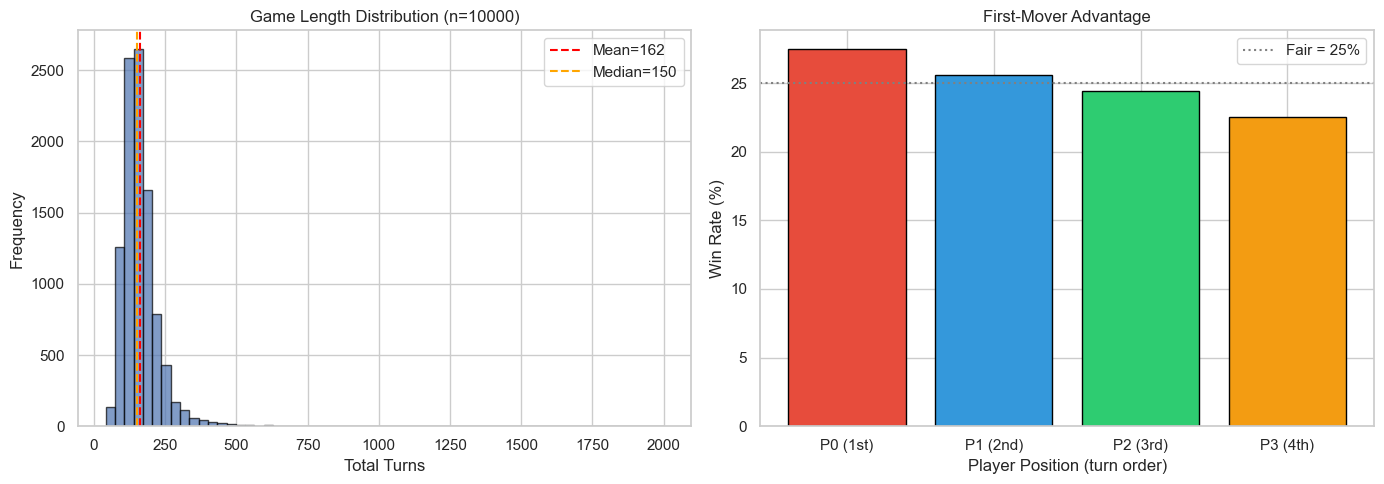

  2 players: P0=52.1% (fair=50.0%, advantage=+2.1pp)
  3 players: P0=36.0% (fair=33.3%, advantage=+2.7pp)
  4 players: P0=26.7% (fair=25.0%, advantage=+1.7pp)
  5 players: P0=22.1% (fair=20.0%, advantage=+2.1pp)
  6 players: P0=18.0% (fair=16.7%, advantage=+1.3pp)


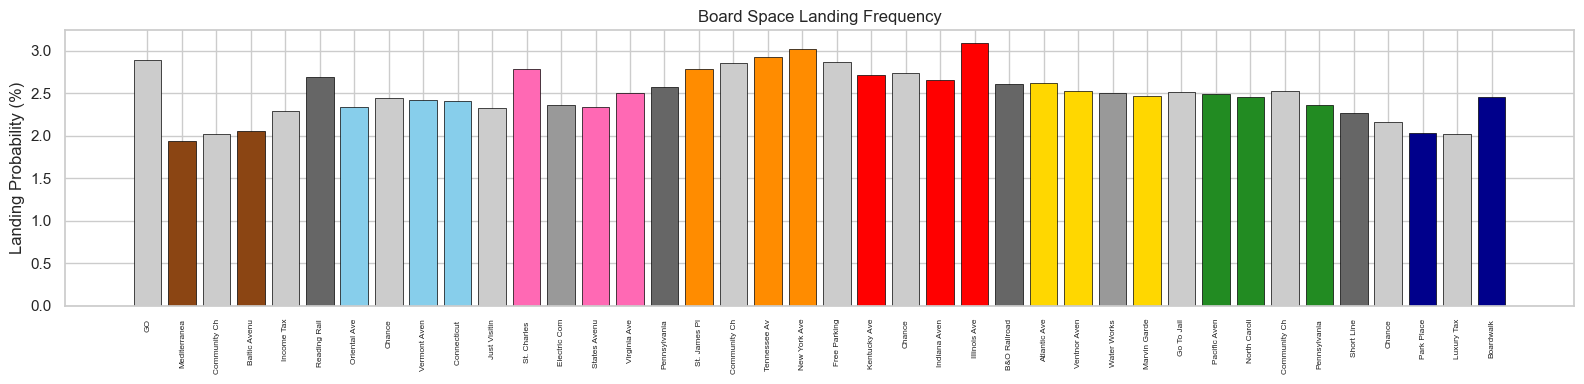

Top 10 most-landed spaces:
  1. Illinois Avenue (3.08%)
  2. New York Avenue (3.02%)
  3. Tennessee Avenue (2.92%)
  4. GO (2.89%)
  5. Free Parking (2.86%)
  6. Community Chest (2.86%)
  7. St. James Place (2.78%)
  8. St. Charles Place (2.78%)
  9. Chance (2.74%)
  10. Kentucky Avenue (2.72%)


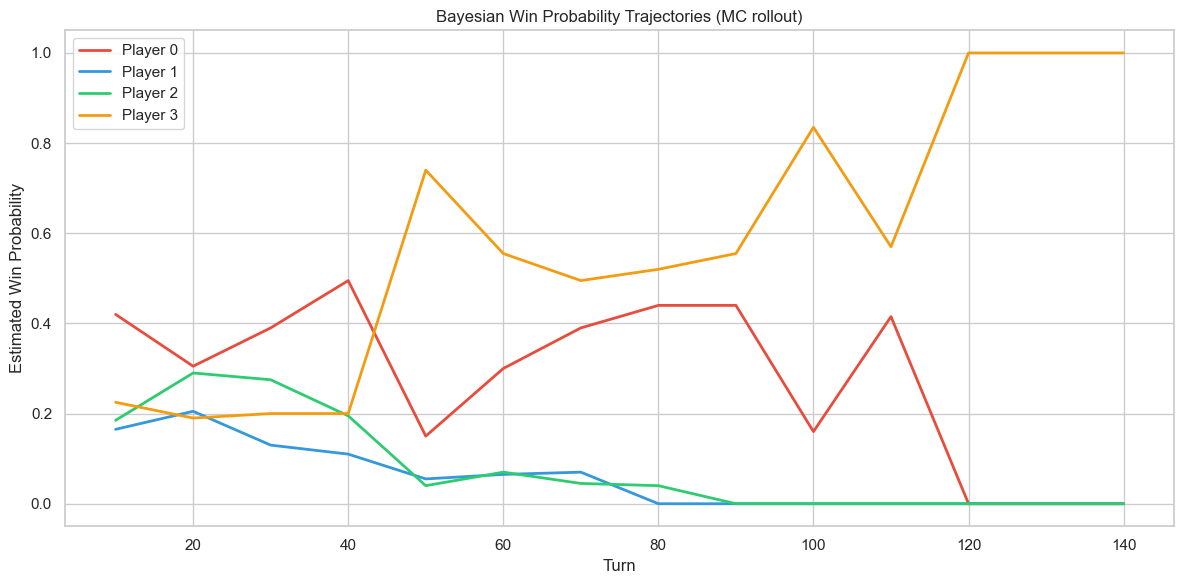

Game ended turn 140, Winner: P3
Top 15 properties by total rent collected per game:
Property                  Avg Rent/Game  Price      ROI
-------------------------------------------------------
  Boardwalk               A      1009   A 400    252.1%
  Park Place              A       742   A 350    212.0%
  St. James Place         A       464   A 180    258.0%
  New York Avenue         A       453   A 200    226.7%
  Baltic Avenue           A       445   A  60    741.3%
  Tennessee Avenue        A       426   A 180    236.5%
  St. Charles Place       A       406   A 140    290.0%
  Virginia Avenue         A       372   A 160    232.2%
  Illinois Avenue         A       368   A 240    153.2%
  Kentucky Avenue         A       361   A 220    164.3%
  Connecticut Avenue      A       349   A 120    290.7%
  Atlantic Avenue         A       345   A 260    132.7%
  Vermont Avenue          A       343   A 100    342.6%
  Oriental Avenue         A       340   A 100    340.5%
  States Avenue     

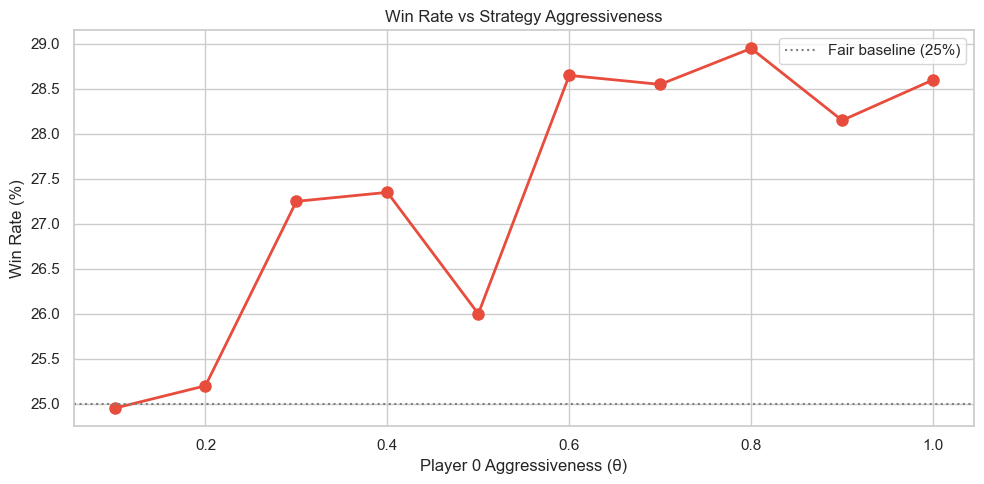

  θ=0.1: 24.9%
  θ=0.2: 25.2%
  θ=0.3: 27.3%
  θ=0.4: 27.4%
  θ=0.5: 26.0%
  θ=0.6: 28.6%
  θ=0.7: 28.5%
  θ=0.8: 28.9%
  θ=0.9: 28.1%
  θ=1.0: 28.6%


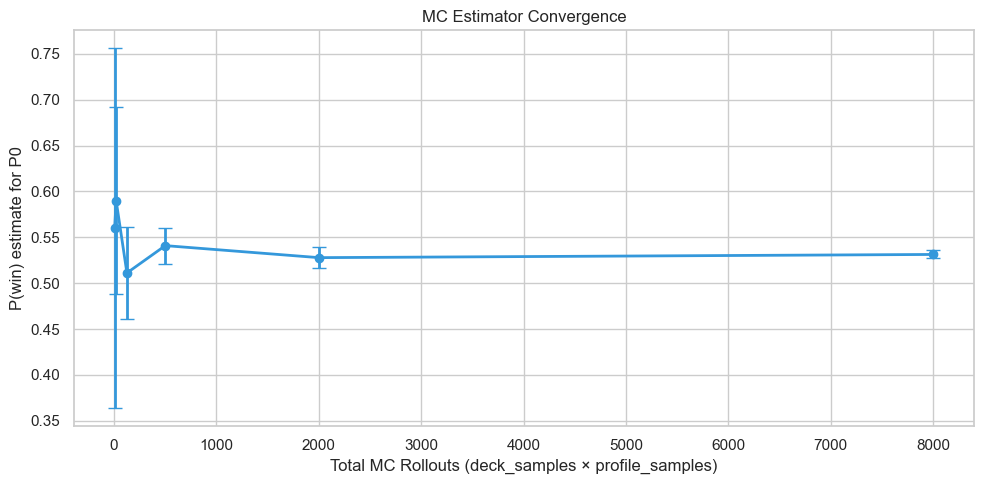

Rollouts | Mean P(win) | Std
       5 | 0.560       | 0.196
      20 | 0.590       | 0.102
     125 | 0.511       | 0.051
     500 | 0.541       | 0.019
    2000 | 0.528       | 0.012
    8000 | 0.531       | 0.004


In [10]:
"""
Monopoly POMDP — Analysis Notebook

"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from time import time

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

# ============================================================
# CELL 2: Large-scale baseline — statistical significance
# ============================================================
"""
Run 10,000 games to get tight confidence intervals on win rates
and characterize the game-length distribution.
"""
N = 10_000
wins = defaultdict(int)
lengths = []
bankruptcies_at = defaultdict(list)  # turn when each player goes bankrupt

t0 = time()
for _ in range(N):
    g = MonopolyPOMDP(num_players=4)
    w = g.simulate_game(max_turns=2000)
    wins[w] += 1
    lengths.append(g.state.obs.turn_number)
    for p in g.state.obs.players:
        if p.is_bankrupt:
            # Approximate bankruptcy turn from final turn count
            pass  # We'd need per-player tracking for exact timing

elapsed = time() - t0
print(f"Ran {N} games in {elapsed:.1f}s ({N/elapsed:.0f} games/sec)\n")

for i in range(4):
    rate = wins[i] / N * 100
    # 95% CI via normal approx to binomial
    se = np.sqrt(rate * (100 - rate) / N)
    print(f"  Player {i}: {rate:.2f}% ± {1.96*se:.2f}%")
print(f"  Draws: {wins[-1]/N*100:.2f}%")
print(f"\nGame length: mean={np.mean(lengths):.0f}, "
      f"median={np.median(lengths):.0f}, "
      f"std={np.std(lengths):.0f}")

# ============================================================
# CELL 3: Visualize game length distribution
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(lengths, bins=60, edgecolor="black", alpha=0.7, color="#4C72B0")
axes[0].axvline(np.mean(lengths), color="red", linestyle="--",
                label=f"Mean={np.mean(lengths):.0f}")
axes[0].axvline(np.median(lengths), color="orange", linestyle="--",
                label=f"Median={np.median(lengths):.0f}")
axes[0].set_xlabel("Total Turns")
axes[0].set_ylabel("Frequency")
axes[0].set_title(f"Game Length Distribution (n={N})")
axes[0].legend()

# Win rate by player position
positions = list(range(4))
rates = [wins[i] / N * 100 for i in positions]
colors = ["#e74c3c", "#3498db", "#2ecc71", "#f39c12"]
axes[1].bar(positions, rates, color=colors, edgecolor="black")
axes[1].axhline(25, color="gray", linestyle=":", label="Fair = 25%")
axes[1].set_xlabel("Player Position (turn order)")
axes[1].set_ylabel("Win Rate (%)")
axes[1].set_title("First-Mover Advantage")
axes[1].set_xticks(positions)
axes[1].set_xticklabels(["P0 (1st)", "P1 (2nd)", "P2 (3rd)", "P3 (4th)"])
axes[1].legend()

plt.tight_layout()
plt.savefig("monopoly_baseline.png", dpi=150, bbox_inches="tight")
plt.show()


# ============================================================
# CELL 4: First-mover advantage — vary player count
# ============================================================
"""
How does first-mover advantage scale with 2, 3, 4, 5, 6 players?
"""
results_by_n = {}
for np_ in [2, 3, 4, 5, 6]:
    w = defaultdict(int)
    for _ in range(2000):
        g = MonopolyPOMDP(num_players=np_)
        winner = g.simulate_game(max_turns=2000)
        w[winner] += 1
    fair = 100 / np_
    p0_rate = w[0] / 2000 * 100
    results_by_n[np_] = {"fair": fair, "p0": p0_rate,
                          "advantage": p0_rate - fair}
    print(f"  {np_} players: P0={p0_rate:.1f}% (fair={fair:.1f}%, "
          f"advantage=+{p0_rate-fair:.1f}pp)")


# ============================================================
# CELL 5: Property landing frequency heat map
# ============================================================
"""
Which properties get landed on most?
Run games and count landing frequency per space.
"""
landing_counts = np.zeros(40)
N_FREQ = 5000

for _ in range(N_FREQ):
    g = MonopolyPOMDP(num_players=4)
    # Instrument: count landings during game
    orig_handle = g._handle_landing

    def counting_handle(player, dice_roll, _orig=orig_handle):
        landing_counts[player.position] += 1
        _orig(player, dice_roll)

    g._handle_landing = counting_handle
    g.simulate_game(max_turns=500)

# Normalize to probability
landing_probs = landing_counts / landing_counts.sum()

fig, ax = plt.subplots(figsize=(16, 4))
space_names = [BOARD[i].name[:12] for i in range(40)]
bar_colors = []
for i in range(40):
    if i in PROPERTY_DEFS:
        pd = PROPERTY_DEFS[i]
        cmap = {
            ColorSet.BROWN: "#8B4513", ColorSet.LIGHT_BLUE: "#87CEEB",
            ColorSet.PINK: "#FF69B4", ColorSet.ORANGE: "#FF8C00",
            ColorSet.RED: "#FF0000", ColorSet.YELLOW: "#FFD700",
            ColorSet.GREEN: "#228B22", ColorSet.DARK_BLUE: "#00008B",
            ColorSet.RAILROAD: "#666666", ColorSet.UTILITY: "#999999",
        }
        bar_colors.append(cmap.get(pd.color, "#CCCCCC"))
    else:
        bar_colors.append("#CCCCCC")

ax.bar(range(40), landing_probs * 100, color=bar_colors, edgecolor="black",
       linewidth=0.5)
ax.set_xticks(range(40))
ax.set_xticklabels(space_names, rotation=90, fontsize=6)
ax.set_ylabel("Landing Probability (%)")
ax.set_title("Board Space Landing Frequency")
plt.tight_layout()
plt.savefig("monopoly_landing_freq.png", dpi=150, bbox_inches="tight")
plt.show()

# Top 10 most landed-on
ranked = sorted(range(40), key=lambda i: -landing_counts[i])
print("Top 10 most-landed spaces:")
for i, pos in enumerate(ranked[:10]):
    print(f"  {i+1}. {BOARD[pos].name} ({landing_probs[pos]*100:.2f}%)")


# ============================================================
# CELL 6: Win probability trajectories — better sampling
# ============================================================
"""
Track win probability over a single game with higher MC samples
for smoother curves.
"""
game = MonopolyPOMDP(num_players=4, seed=777)
estimator = WinLikelihoodEstimator(
    num_deck_samples=20,      # ← increased from 5
    num_profile_samples=10,   # ← increased from 3
    max_rollout_turns=400,
    seed=888
)

trajectory = {i: [] for i in range(4)}
turns = []

while not game.is_terminal() and game.state.obs.turn_number < 1000:
    game.play_turn()
    if game.state.obs.turn_number % 10 == 0:
        obs = game.get_observation(0)
        probs = estimator.estimate(obs, focus_player=0, num_players=4)
        turns.append(game.state.obs.turn_number)
        for i in range(4):
            trajectory[i].append(probs.get(i, 0.0))

fig, ax = plt.subplots(figsize=(12, 6))
colors = ["#e74c3c", "#3498db", "#2ecc71", "#f39c12"]
for i in range(4):
    ax.plot(turns, trajectory[i], label=f"Player {i}",
            color=colors[i], linewidth=2)
ax.set_xlabel("Turn")
ax.set_ylabel("Estimated Win Probability")
ax.set_title("Bayesian Win Probability Trajectories (MC rollout)")
ax.legend()
ax.set_ylim(-0.05, 1.05)
plt.tight_layout()
plt.savefig("monopoly_win_trajectory.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Game ended turn {game.state.obs.turn_number}, "
      f"Winner: P{game.winner()}")


# ============================================================
# CELL 7: ROI analysis — which properties are most profitable?
# ============================================================
"""
Track total rent collected per property across many games.
"""
from collections import Counter

rent_collected = Counter()  # pos -> total rent
N_ROI = 3000

for _ in range(N_ROI):
    g = MonopolyPOMDP(num_players=4)
    orig_calc = g.calculate_rent

    def tracking_rent(pos, dice_roll=0, _orig=orig_calc):
        r = _orig(pos, dice_roll)
        if r > 0:
            rent_collected[pos] += r
        return r

    g.calculate_rent = tracking_rent
    g.simulate_game(max_turns=1000)

# Normalize by number of games and property price
print("Top 15 properties by total rent collected per game:")
print(f"{'Property':<25} {'Avg Rent/Game':>13} {'Price':>6} {'ROI':>8}")
print("-" * 55)

sorted_props = sorted(rent_collected.keys(),
                       key=lambda p: -rent_collected[p])
for pos in sorted_props[:15]:
    pd = PROPERTY_DEFS[pos]
    avg_rent = rent_collected[pos] / N_ROI
    roi = avg_rent / pd.price * 100
    print(f"  {pd.name:<23} A{avg_rent:>10.0f}   A{pd.price:>4}   {roi:>6.1f}%")


# ============================================================
# CELL 8: PPO Training
# ============================================================
"""
Train a PPO agent. (RL component)
Note: the agent controls ONE player; opponents use heuristics.
Training 200k steps takes ~5-10 min.
"""
# Uncomment to train:
# model, env = train_ppo(total_timesteps=200_000, seed=2629)

# Quick sanity check with shorter training:
model, env = train_ppo(total_timesteps=50_000, verbose=1, seed=2629)


# ============================================================
# CELL 9: Evaluate PPO agent vs heuristic baseline
# ============================================================
"""
Compare trained agent win rate against the heuristic baseline.
The agent is Player 0.
"""
if model is not None:
    n_eval = 500
    agent_wins = 0
    heuristic_p0_wins = 0

    # Agent games
    for _ in range(n_eval):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        if env.game.winner() == 0:
            agent_wins += 1

    # Heuristic baseline for P0
    for _ in range(n_eval):
        g = MonopolyPOMDP(num_players=4)
        w = g.simulate_game(max_turns=2000)
        if w == 0:
            heuristic_p0_wins += 1

    print(f"PPO Agent (P0):      {agent_wins/n_eval*100:.1f}% "
          f"({agent_wins}/{n_eval})")
    print(f"Heuristic (P0):      {heuristic_p0_wins/n_eval*100:.1f}% "
          f"({heuristic_p0_wins}/{n_eval})")
    print(f"Improvement:         "
          f"{(agent_wins-heuristic_p0_wins)/n_eval*100:+.1f}pp")


# ============================================================
# CELL 10: Sensitivity analysis — how much does strategy matter?
# ============================================================
"""
Compare aggressive (θ→1) vs conservative (θ→0) fixed strategies
to quantify how much player behavior affects outcomes.
"""

def run_fixed_profile(profile_value: float, n_games: int = 2000):
    """Run games where P0 has a fixed profile; others are random."""
    w = 0
    for _ in range(n_games):
        g = MonopolyPOMDP(num_players=4)
        g.state.hidden.opponent_profiles[0] = profile_value
        winner = g.simulate_game(max_turns=2000)
        if winner == 0:
            w += 1
    return w / n_games * 100

profiles = np.linspace(0.1, 1.0, 10)
win_rates = [run_fixed_profile(p) for p in profiles]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(profiles, win_rates, "o-", color="#e74c3c", linewidth=2,
        markersize=8)
ax.axhline(25, color="gray", linestyle=":", label="Fair baseline (25%)")
ax.set_xlabel("Player 0 Aggressiveness (θ)")
ax.set_ylabel("Win Rate (%)")
ax.set_title("Win Rate vs Strategy Aggressiveness")
ax.legend()
plt.tight_layout()
plt.savefig("monopoly_strategy_sensitivity.png", dpi=150,
            bbox_inches="tight")
plt.show()

for p, wr in zip(profiles, win_rates):
    print(f"  θ={p:.1f}: {wr:.1f}%")


# ============================================================
# CELL 11: Monte Carlo convergence check
# ============================================================
"""
How many MC rollouts does the WinLikelihoodEstimator need?
Check convergence of estimates as sample size increases.
"""
game = MonopolyPOMDP(num_players=4, seed=999)
# Play 60 turns to get an interesting mid-game state
for _ in range(60):
    game.play_turn()
    if game.is_terminal():
        break

obs = game.get_observation(0)
sample_sizes = [5, 10, 25, 50, 100, 200]
estimates = {n: [] for n in sample_sizes}

for n_deck in sample_sizes:
    n_profile = max(1, n_deck // 5)
    for trial in range(10):
        est = WinLikelihoodEstimator(
            num_deck_samples=n_deck, num_profile_samples=n_profile,
            max_rollout_turns=300, seed=trial * 100
        )
        probs = est.estimate(obs, focus_player=0, num_players=4)
        estimates[n_deck].append(probs.get(0, 0.0))

fig, ax = plt.subplots(figsize=(10, 5))
means = [np.mean(estimates[n]) for n in sample_sizes]
stds = [np.std(estimates[n]) for n in sample_sizes]
total_rollouts = [n * max(1, n // 5) for n in sample_sizes]

ax.errorbar(total_rollouts, means, yerr=stds, fmt="o-", capsize=5,
            color="#3498db", linewidth=2)
ax.set_xlabel("Total MC Rollouts (deck_samples × profile_samples)")
ax.set_ylabel("P(win) estimate for P0")
ax.set_title("MC Estimator Convergence")
plt.tight_layout()
plt.savefig("monopoly_mc_convergence.png", dpi=150, bbox_inches="tight")
plt.show()

print("Rollouts | Mean P(win) | Std")
for n, m, s in zip(total_rollouts, means, stds):
    print(f"  {n:>6} | {m:.3f}       | {s:.3f}")

In [11]:
"""
Monopoly Scenario Builder
==========================
Set up any board state and estimate win probabilities.
Depends on: monopoly_pomdp.py (Part 1) and monopoly_rl.py (Part 2)

Usage:
    %run monopoly_pomdp.py
    %run monopoly_rl.py
    %run monopoly_scenario.py

    # Then use ScenarioBuilder (see examples at bottom)
"""

from __future__ import annotations
from dataclasses import dataclass, field
from copy import deepcopy
from typing import Optional
import numpy as np

# ============================================================
# SCENARIO BUILDER
# ============================================================

# Convenient name -> position lookup
PROPERTY_BY_NAME: dict[str, int] = {}
for _pos, _pd in PROPERTY_DEFS.items():
    PROPERTY_BY_NAME[_pd.name.lower()] = _pos
    # Also add short aliases
    short = _pd.name.split()[0].lower()
    if short not in PROPERTY_BY_NAME:
        PROPERTY_BY_NAME[short] = _pos

# Add common aliases
_ALIASES = {
    "mediterranean": 1, "med": 1, "baltic": 3,
    "oriental": 6, "vermont": 8, "connecticut": 9,
    "st. charles": 11, "st charles": 11, "charles": 11,
    "states": 13, "virginia": 14,
    "st. james": 16, "st james": 16, "james": 16,
    "tennessee": 18, "new york": 19,
    "kentucky": 21, "indiana": 23, "illinois": 24,
    "atlantic": 26, "ventnor": 27, "marvin": 29, "marvin gardens": 29,
    "pacific": 31, "north carolina": 32, "carolina": 32,
    "pennsylvania ave": 34, "penn ave": 34,
    "park": 37, "park place": 37, "boardwalk": 39,
    "reading": 5, "reading rr": 5,
    "penn rr": 15, "pennsylvania rr": 15, "pennsylvania railroad": 15,
    "b&o": 25, "b&o railroad": 25, "bno": 25,
    "short line": 35, "shortline": 35,
    "electric": 12, "electric company": 12,
    "water": 28, "water works": 28,
}
PROPERTY_BY_NAME.update(_ALIASES)


def resolve_property(name_or_pos) -> int:
    """Convert a property name or position to board position."""
    if isinstance(name_or_pos, int):
        if name_or_pos in PROPERTY_DEFS:
            return name_or_pos
        raise ValueError(f"Position {name_or_pos} is not a property")
    key = str(name_or_pos).lower().strip()
    if key in PROPERTY_BY_NAME:
        return PROPERTY_BY_NAME[key]
    # Fuzzy match
    for k, v in PROPERTY_BY_NAME.items():
        if key in k or k in key:
            return v
    raise ValueError(
        f"Unknown property: '{name_or_pos}'. "
        f"Use a name like 'boardwalk', 'illinois', 'reading rr', etc."
    )


@dataclass
class PlayerSetup:
    """Configuration for one player in a scenario."""
    cash: int = STARTING_CASH
    position: int = 0
    properties: list = field(default_factory=list)  # names or positions
    houses: dict = field(default_factory=dict)       # {prop: num_houses} (5=hotel)
    mortgaged: list = field(default_factory=list)     # names or positions
    in_jail: bool = False
    jail_turns: int = 0
    has_goojf_chance: bool = False
    has_goojf_cc: bool = False
    is_bankrupt: bool = False


class ScenarioBuilder:
    """
    Build a custom Monopoly board state and estimate win probabilities.

    Example:
        sb = ScenarioBuilder(num_players=4)
        sb.set_player(0, cash=800, properties=["boardwalk", "park place"],
                      houses={"boardwalk": 3, "park place": 3})
        sb.set_player(1, cash=1200, properties=["illinois", "indiana", "kentucky"])
        sb.set_player(2, cash=500, properties=["reading rr", "b&o"])
        sb.set_player(3, cash=200)  # poor player, no properties

        probs = sb.estimate_win_probabilities()
        sb.print_scenario()
    """

    def __init__(self, num_players: int = 4):
        self.num_players = num_players
        self.player_setups: dict[int, PlayerSetup] = {
            i: PlayerSetup() for i in range(num_players)
        }
        self.current_player: int = 0

    def set_player(self, player_idx: int, **kwargs) -> "ScenarioBuilder":
        """
        Configure a player.

        Args:
            player_idx: 0-based player index
            cash: Cash on hand
            position: Board position (0-39)
            properties: List of property names or positions owned
            houses: Dict of {property: house_count} (5 = hotel)
            mortgaged: List of mortgaged property names or positions
            in_jail: Whether the player is in jail
            jail_turns: Turns spent in jail so far
            has_goojf_chance: Has Chance GOOJF card
            has_goojf_cc: Has Community Chest GOOJF card
            is_bankrupt: Whether the player is bankrupt
        """
        if player_idx >= self.num_players:
            raise ValueError(f"Player {player_idx} out of range (0-{self.num_players-1})")
        setup = self.player_setups[player_idx]
        for k, v in kwargs.items():
            if hasattr(setup, k):
                setattr(setup, k, v)
            else:
                raise ValueError(f"Unknown player attribute: {k}")
        return self

    def set_current_player(self, idx: int) -> "ScenarioBuilder":
        """Set whose turn it is."""
        self.current_player = idx
        return self

    def _build_observable_state(self) -> ObservableState:
        """Convert scenario config into a full ObservableState."""
        obs = ObservableState(
            players=[],
            properties={pos: PropertyState(position=pos) for pos in PROPERTY_DEFS},
            houses_available=MAX_HOUSES,
            hotels_available=MAX_HOTELS,
            current_player=self.current_player,
            turn_number=0,
        )

        # Build player states
        for i in range(self.num_players):
            setup = self.player_setups[i]
            ps = PlayerState(
                index=i,
                cash=setup.cash,
                position=setup.position,
                in_jail=setup.in_jail,
                jail_turns=setup.jail_turns,
                has_goojf_chance=setup.has_goojf_chance,
                has_goojf_cc=setup.has_goojf_cc,
                is_bankrupt=setup.is_bankrupt,
            )
            obs.players.append(ps)

            # Assign properties
            for prop in setup.properties:
                pos = resolve_property(prop)
                obs.properties[pos].owner = i

            # Assign houses
            for prop, count in setup.houses.items():
                pos = resolve_property(prop)
                if obs.properties[pos].owner != i:
                    raise ValueError(
                        f"Player {i} has houses on {PROPERTY_DEFS[pos].name} "
                        f"but doesn't own it. Add it to properties list first."
                    )
                obs.properties[pos].houses = count
                if count == 5:
                    obs.hotels_available -= 1
                else:
                    obs.houses_available -= count

            # Assign mortgages
            for prop in setup.mortgaged:
                pos = resolve_property(prop)
                if obs.properties[pos].owner != i:
                    raise ValueError(
                        f"Player {i} mortgaging {PROPERTY_DEFS[pos].name} "
                        f"but doesn't own it."
                    )
                obs.properties[pos].is_mortgaged = True

        # Validation
        self._validate(obs)

        # Set deck vectors to uniform (no card history)
        chance_cards = _build_chance_deck()
        cc_cards = _build_cc_deck()
        # Remove GOOJF if held
        for p in obs.players:
            if p.has_goojf_chance:
                chance_cards = [c for c in chance_cards
                                if c.action != CardAction.GET_OUT_OF_JAIL]
            if p.has_goojf_cc:
                cc_cards = [c for c in cc_cards
                            if c.action != CardAction.GET_OUT_OF_JAIL]
        n_ch = len(chance_cards)
        n_cc = len(cc_cards)
        obs.chance_remaining = {}
        for c in chance_cards:
            obs.chance_remaining[c.name] = obs.chance_remaining.get(c.name, 0) + 1
        if n_ch > 0:
            for k in obs.chance_remaining:
                obs.chance_remaining[k] /= n_ch
        obs.cc_remaining = {}
        for c in cc_cards:
            obs.cc_remaining[c.name] = obs.cc_remaining.get(c.name, 0) + 1
        if n_cc > 0:
            for k in obs.cc_remaining:
                obs.cc_remaining[k] /= n_cc

        return obs

    def _validate(self, obs: ObservableState):
        """Check for illegal states."""
        errors = []

        # Check no property assigned to multiple players
        for pos, ps in obs.properties.items():
            if ps.owner is not None and obs.players[ps.owner].is_bankrupt:
                errors.append(f"Bankrupt P{ps.owner} owns {PROPERTY_DEFS[pos].name}")

        # Check even building rule
        for color in STREET_COLORS:
            positions = COLOR_SET_POSITIONS[color]
            owners = set(obs.properties[p].owner for p in positions
                         if obs.properties[p].owner is not None)
            # Only check if one player owns all
            for owner in owners:
                owned_in_set = [p for p in positions
                                if obs.properties[p].owner == owner]
                if len(owned_in_set) == len(positions):
                    houses = [obs.properties[p].houses for p in positions]
                    non_hotel = [h for h in houses if h < 5]
                    if non_hotel and max(non_hotel) - min(non_hotel) > 1:
                        pd_name = PROPERTY_DEFS[positions[0]].color.value
                        errors.append(
                            f"Even build violation in {pd_name}: "
                            f"houses={houses}"
                        )
                else:
                    # Doesn't own full set — no buildings allowed
                    for p in owned_in_set:
                        if obs.properties[p].houses > 0:
                            errors.append(
                                f"P{owner} has houses on "
                                f"{PROPERTY_DEFS[p].name} without full "
                                f"{PROPERTY_DEFS[p].color.value} set"
                            )

        # Check building on mortgaged set
        for color in STREET_COLORS:
            positions = COLOR_SET_POSITIONS[color]
            has_mortgage = any(obs.properties[p].is_mortgaged for p in positions)
            has_houses = any(obs.properties[p].houses > 0 for p in positions)
            if has_mortgage and has_houses:
                errors.append(
                    f"Buildings exist in {PROPERTY_DEFS[positions[0]].color.value} "
                    f"set with mortgaged property"
                )

        # Check house/hotel supply
        if obs.houses_available < 0:
            errors.append(f"House supply negative: {obs.houses_available}")
        if obs.hotels_available < 0:
            errors.append(f"Hotel supply negative: {obs.hotels_available}")

        if errors:
            raise ValueError(
                "Invalid scenario:\n  " + "\n  ".join(errors)
            )

    def estimate_win_probabilities(
        self,
        num_deck_samples: int = 30,
        num_profile_samples: int = 10,
        max_rollout_turns: int = 500,
        seed: int | None = None
    ) -> dict[int, float]:
        """
        Estimate win probability for each player from the configured state.

        Args:
            num_deck_samples: Number of deck permutations to sample
            num_profile_samples: Number of opponent profiles per deck
            max_rollout_turns: Max turns per rollout game
            seed: RNG seed for reproducibility

        Returns:
            {player_idx: win_probability}
        """
        obs = self._build_observable_state()

        estimator = WinLikelihoodEstimator(
            num_deck_samples=num_deck_samples,
            num_profile_samples=num_profile_samples,
            max_rollout_turns=max_rollout_turns,
            seed=seed,
        )

        probs = estimator.estimate(obs, focus_player=0,
                                    num_players=self.num_players)
        return probs

    def print_scenario(self):
        """Pretty-print the scenario configuration."""
        obs = self._build_observable_state()
        print("=" * 60)
        print("SCENARIO")
        print("=" * 60)

        for i in range(self.num_players):
            p = obs.players[i]
            status = "BANKRUPT" if p.is_bankrupt else (
                "IN JAIL" if p.in_jail else "Active")
            print(f"\nPlayer {i} [{status}] — Cash: A{p.cash}")

            props = obs.props_owned_by(i)
            if props:
                for ps in sorted(props, key=lambda x: x.position):
                    pd = PROPERTY_DEFS[ps.position]
                    flags = []
                    if ps.is_mortgaged:
                        flags.append("MORTGAGED")
                    if ps.houses == 5:
                        flags.append("HOTEL")
                    elif ps.houses > 0:
                        flags.append(f"{ps.houses} house{'s' if ps.houses > 1 else ''}")
                    flag_str = f" [{', '.join(flags)}]" if flags else ""
                    print(f"  • {pd.name} ({pd.color.value}){flag_str}")
            else:
                print("  (no properties)")

            nav = obs.net_asset_value(i)
            print(f"  Net Asset Value: A{nav}")

        print(f"\nHouse supply: {obs.houses_available}/{MAX_HOUSES}")
        print(f"Hotel supply: {obs.hotels_available}/{MAX_HOTELS}")
        print("=" * 60)

    def sweep_parameter(
        self,
        player_idx: int,
        parameter: str,
        values: list,
        samples: int = 30,
        seed: int = 42
    ) -> dict:
        """
        Sweep a single parameter and see how win probability changes.

        Args:
            player_idx: Which player to modify
            parameter: 'cash', or a property name for house count
            values: List of values to test
            samples: MC samples per estimate

        Returns:
            {value: {player: win_prob}}
        """
        results = {}
        original_setup = deepcopy(self.player_setups[player_idx])

        for val in values:
            if parameter == "cash":
                self.player_setups[player_idx].cash = val
            else:
                # Assume it's a property — sweep house count
                pos = resolve_property(parameter)
                self.player_setups[player_idx].houses[parameter] = val

            try:
                probs = self.estimate_win_probabilities(
                    num_deck_samples=samples,
                    num_profile_samples=max(3, samples // 10),
                    seed=seed
                )
                results[val] = probs
            except ValueError as e:
                results[val] = {"error": str(e)}

            # Restore
            self.player_setups[player_idx] = deepcopy(original_setup)

        return results


# ============================================================
# CONVENIENCE FUNCTIONS
# ============================================================

def quick_estimate(player_configs: list[dict], **kwargs) -> dict[int, float]:
    """
    One-liner win probability estimation.

    Args:
        player_configs: List of dicts, one per player. Keys:
            cash, properties, houses, mortgaged, in_jail, etc.

    Example:
        quick_estimate([
            {"cash": 800, "properties": ["boardwalk", "park place"],
             "houses": {"boardwalk": 4, "park place": 4}},
            {"cash": 1500, "properties": ["illinois", "indiana", "kentucky"]},
            {"cash": 600},
            {"cash": 300},
        ])
    """
    sb = ScenarioBuilder(num_players=len(player_configs))
    for i, cfg in enumerate(player_configs):
        sb.set_player(i, **cfg)
    probs = sb.estimate_win_probabilities(**kwargs)
    # Print summary
    for i, p in sorted(probs.items()):
        print(f"  Player {i}: {p*100:.1f}%")
    return probs


def list_properties():
    """Print all property names for reference."""
    print(f"{'Pos':<4} {'Name':<25} {'Color':<12} {'Price':<6} "
          f"{'House':<6} {'Base Rent'}")
    print("-" * 70)
    for pos in PROPERTY_POSITIONS:
        pd = PROPERTY_DEFS[pos]
        color = pd.color.value if pd.color else ""
        base_rent = pd.rent[0] if pd.rent else 0
        hcost = pd.house_cost if pd.house_cost else "-"
        print(f"  {pos:<3} {pd.name:<25} {color:<12} A{pd.price:<5} "
              f"A{str(hcost):<5} A{base_rent}")


# ============================================================
# EXAMPLES — paste into Jupyter cells
# ============================================================

if __name__ == "__main__":
    print("=" * 60)
    print("EXAMPLE 1: Classic late-game showdown")
    print("=" * 60)

    sb = ScenarioBuilder(num_players=3)

    # Player 0: Owns dark blue with hotels — expensive but sparse
    sb.set_player(0,
        cash=400,
        properties=["boardwalk", "park place", "reading rr"],
        houses={"boardwalk": 5, "park place": 5},  # 5 = hotel
    )

    # Player 1: Owns orange set (high traffic) with 3 houses each
    sb.set_player(1,
        cash=600,
        properties=["st james", "tennessee", "new york",
                     "pennsylvania railroad", "b&o"],
        houses={"st james": 3, "tennessee": 3, "new york": 3},
    )

    # Player 2: Cash-rich but no monopoly
    sb.set_player(2,
        cash=1800,
        properties=["illinois", "kentucky", "electric", "short line"],
    )

    sb.print_scenario()
    print("\nEstimating win probabilities (300 rollouts)...")
    probs = sb.estimate_win_probabilities(
        num_deck_samples=30, num_profile_samples=10, seed=2629
    )
    print("\nResults:")
    for i, p in sorted(probs.items()):
        print(f"  Player {i}: {p*100:.1f}%")

    # ----------------------------------------------------------
    print("\n" + "=" * 60)
    print("EXAMPLE 2: Does one extra house matter?")
    print("=" * 60)

    sb2 = ScenarioBuilder(num_players=2)
    sb2.set_player(0,
        cash=500,
        properties=["boardwalk", "park place"],
        houses={"boardwalk": 2, "park place": 2},
    )
    sb2.set_player(1,
        cash=500,
        properties=["illinois", "indiana", "kentucky"],
        houses={"illinois": 2, "indiana": 2, "kentucky": 2},
    )

    print("Sweeping house count on Boardwalk (P0)...")
    results = sb2.sweep_parameter(0, "cash", [200, 500, 800, 1200, 1500],
                                   samples=20, seed=2629)
    print(f"\n{'P0 Cash':<10} {'P0 Win%':<10} {'P1 Win%':<10}")
    print("-" * 30)
    for val, probs in results.items():
        if "error" not in probs:
            print(f"  A{val:<7} {probs.get(0,0)*100:<9.1f} "
                  f"{probs.get(1,0)*100:<9.1f}")
        else:
            print(f"  A{val:<7} {probs['error']}")

    # ----------------------------------------------------------
    print("\n" + "=" * 60)
    print("EXAMPLE 3: Quick one-liner")
    print("=" * 60)
    print("Hotels on Boardwalk/Park Place vs 3 houses on Orange:")
    quick_estimate([
        {"cash": 200, "properties": ["boardwalk", "park place"],
         "houses": {"boardwalk": 5, "park place": 5}},
        {"cash": 1000, "properties": ["st james", "tennessee", "new york"],
         "houses": {"st james": 3, "tennessee": 3, "new york": 3}},
    ], num_deck_samples=30, num_profile_samples=10, seed=2629)

EXAMPLE 1: Classic late-game showdown
SCENARIO

Player 0 [Active] — Cash: A400
  • Reading Railroad (Railroad)
  • Park Place (DarkBlue) [HOTEL]
  • Boardwalk (DarkBlue) [HOTEL]
  Net Asset Value: A3350

Player 1 [Active] — Cash: A600
  • Pennsylvania Railroad (Railroad)
  • St. James Place (Orange) [3 houses]
  • Tennessee Avenue (Orange) [3 houses]
  • New York Avenue (Orange) [3 houses]
  • B&O Railroad (Railroad)
  Net Asset Value: A2460

Player 2 [Active] — Cash: A1800
  • Electric Company (Utility)
  • Kentucky Avenue (Red)
  • Illinois Avenue (Red)
  • Short Line (Railroad)
  Net Asset Value: A2610

House supply: 23/32
Hotel supply: 10/12

Estimating win probabilities (300 rollouts)...

Results:
  Player 0: 34.0%
  Player 1: 57.3%
  Player 2: 8.7%

EXAMPLE 2: Does one extra house matter?
Sweeping house count on Boardwalk (P0)...

P0 Cash    P0 Win%    P1 Win%   
------------------------------
  A200     23.3      76.7     
  A500     35.0      65.0     
  A800     30.0      70.0